# Signate開始時のお約束

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [ ]:
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=5d0a72bcb78b6f04330901b13aed9b7251f6b9754bd27bbc5d9b3be63ad81b2b
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [ ]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [ ]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


In [ ]:
!pip install kanjize

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.8 MB/s eta 0:00:00


In [42]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

In [108]:
# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [109]:
# 元のカラム順
colorigin = all_df.columns

<ipython-input-110-8331b9fb236d>:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())


<Axes: >

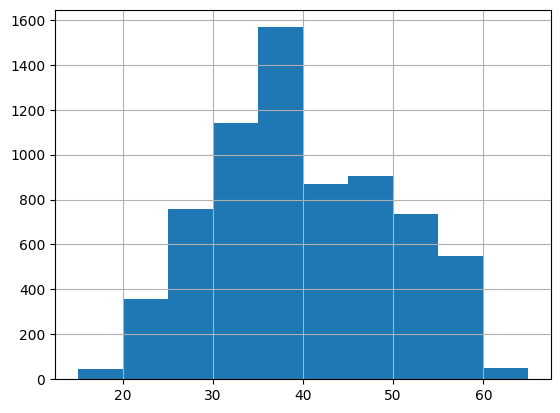

In [110]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1歳")

# Ageの処理
for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10歳で分けて5足す
    tmp = tmp//10 * 10
    all_df.loc[i,"Age"] = tmp + 5
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

# 「-1」はそれ以外の中央値を代入
all_df["Age"] = all_df["Age"].replace(-1,all_df.loc[all_df["Age"]>0,"Age"].median())

# int型にキャストする
all_df["Age"] = all_df["Age"].astype(int)

# ヒストグラムを描く
all_df["Age"].hist()

In [111]:
#########################
# "TypeofContact"の処理 #
#########################
# 欠損は最頻値で補完する
all_df["TypeofContact"] = all_df["TypeofContact"].fillna("Self Enquiry")

# one-hot化して追加する
all_df.loc[all_df["TypeofContact"]=="Self Enquiry","TypeofContact"] = 0
all_df.loc[all_df["TypeofContact"]=="Company Invited","TypeofContact"] = 1

# 列名を変更
all_df = all_df.rename(columns={"TypeofContact":"CompanyInvited"})

print(all_df["CompanyInvited"].value_counts())

CompanyInvited
0    4462
1    2516
Name: count, dtype: int64


In [112]:
#########################
# "CityTier"の処理 #
#########################
print(all_df["CityTier"].value_counts())

CityTier
2    3160
1    2991
3     827
Name: count, dtype: int64


In [113]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(max_row):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("float64")

# 「-1」はそれ以外の中央値を代入
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].replace(-1,all_df.loc[all_df["DurationOfPitch"]>0,"DurationOfPitch"].median())

# 重要でないため、10分刻みのカテゴリにする
all_df["DurationOfPitch"] = (all_df["DurationOfPitch"].values // 10).astype(int)

# 分布を確認する
print(all_df["DurationOfPitch"].value_counts())

DurationOfPitch
1    3824
0    1984
2     709
3     461
Name: count, dtype: int64


In [114]:
####################
# "Occupation"の処理 #
####################
# 特徴量を追加する
all_df["SmallBusiness"] = 0
all_df["Salaried"] = 0
all_df["LargeBusiness"] = 0

# one-hot化して追加する
all_df.loc[all_df["Occupation"]=="Small Business","SmallBusiness"] = 1
all_df.loc[all_df["Occupation"]=="Salaried","Salaried"] = 1
all_df.loc[all_df["Occupation"]=="Large Business","LargeBusiness"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Occupation", axis=1)

print(all_df["SmallBusiness"].value_counts())
print(all_df["Salaried"].value_counts())
print(all_df["LargeBusiness"].value_counts())

SmallBusiness
0    3522
1    3456
Name: count, dtype: int64
Salaried
0    4177
1    2801
Name: count, dtype: int64
LargeBusiness
0    6257
1     721
Name: count, dtype: int64


In [115]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(max_row):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1])
  if(head == "m"):
    all_df.loc[i,"Gender"] = "Male"
  else:
    all_df.loc[i,"Gender"] = "Female"

# one-hot化して追加する
all_df.loc[all_df["Gender"]=="Male","Gender"] = 1
all_df.loc[all_df["Gender"]=="Female","Gender"] = 0

# 列名を変更する
all_df = all_df.rename(columns={"Gender":"Male"})

print(all_df["Male"].value_counts())

Male
0    5946
1    1032
Name: count, dtype: int64


In [116]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
print(all_df["NumberOfPersonVisiting"].value_counts())

NumberOfPersonVisiting
2.0    3163
3.0    2773
1.0     686
4.0     356
Name: count, dtype: int64


In [117]:
##################################
# "NumberOfFollowups"の処理 #
##################################

# 欠損を-1で埋めてから中央値を取る
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].replace(-1,all_df.loc[all_df["NumberOfFollowups"]>0,"NumberOfFollowups"].median())

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 分布の確認
print(all_df["NumberOfFollowups"].value_counts())

NumberOfFollowups
4.0    2834
3.0    2561
5.0    1122
2.0     213
1.0     178
6.0      70
Name: count, dtype: int64


In [118]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

# ラベルエンコード
all_df.loc[all_df["ProductPitched"]=="Basic","ProductPitched"] = 1
all_df.loc[all_df["ProductPitched"]=="Standard","ProductPitched"] = 2
all_df.loc[all_df["ProductPitched"]=="Deluxe","ProductPitched"] = 3
all_df.loc[all_df["ProductPitched"]=="SuperDeluxe","ProductPitched"] = 4
all_df.loc[all_df["ProductPitched"]=="King","ProductPitched"] = 5

# 分布の確認
print(all_df["ProductPitched"].value_counts())

ProductPitched
1    2347
3    2091
2    1614
4     640
5     286
Name: count, dtype: int64


In [119]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
# 順番に意味があるので2引く
all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

# 分布を確認する
all_df["PreferredPropertyStar"].value_counts()

,count
PreferredPropertyStar,
1.0,4328
2.0,2254
3.0,396


In [120]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

# 一旦オブジェクト型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("object")

for i in range(max_row):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][2:3]

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][3:4]

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips"] = all_df.loc[i,"NumberOfTrips"][4:5]

# int型に変更
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].astype("int")

# 「-1」はそれ以外の中央値を代入
all_df["NumberOfTrips"] = all_df["NumberOfTrips"].replace(-1,all_df.loc[all_df["NumberOfTrips"]>0,"NumberOfTrips"].median())

# 3グループに分割する
all_df.loc[all_df["NumberOfTrips"]<4,"NumberOfTrips"] = 1
all_df.loc[(all_df["NumberOfTrips"]>=4)& (all_df["NumberOfTrips"]<6),"NumberOfTrips"] = 2
all_df.loc[all_df["NumberOfTrips"]>=6,"NumberOfTrips"] = 3

# 分布を確認する
all_df["NumberOfTrips"].value_counts()

,count
NumberOfTrips,
1,4854
2,1304
3,820


In [121]:
#########################
# "Passport"の処理 #
#########################
print(all_df["Passport"].value_counts())

Passport
0    6288
1     690
Name: count, dtype: int64


In [122]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df["PitchSatisfactionScore"].value_counts())

PitchSatisfactionScore
2    2500
4    1452
1    1439
3    1344
5     243
Name: count, dtype: int64


In [123]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

# ラベルエンコード
all_df.loc[all_df["Designation"]=="Executive","Designation"] = 5
all_df.loc[all_df["Designation"]=="VP","Designation"] = 4
all_df.loc[all_df["Designation"]=="AVP","Designation"] = 3
all_df.loc[all_df["Designation"]=="Senior Manager","Designation"] = 2
all_df.loc[all_df["Designation"]=="Manager","Designation"] = 1

# 分布の確認
all_df["Designation"].value_counts()

,count
Designation,
5,2330
1,2117
2,1632
3,635
4,264


<Axes: >

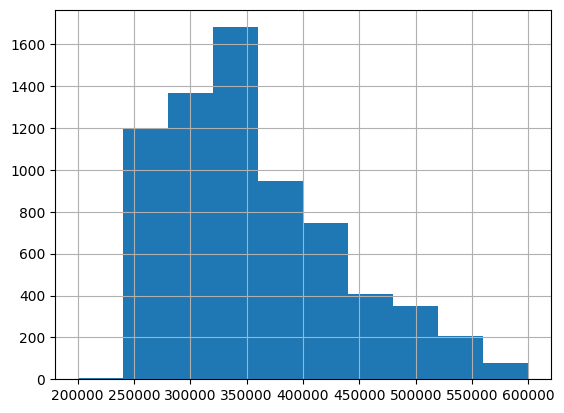

In [124]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(max_row):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

# 「-1」はそれ以外の中央値を代入
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].replace(-1,all_df.loc[all_df["MonthlyIncome"]>0,"MonthlyIncome"].median())

# 分布の確認
all_df["MonthlyIncome"].hist()

In [125]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」、「わからない」
  else:
    c_other.append(cont[i])

In [126]:
# 新たなカラムを追加
all_df["CarHolder"] = 0 # 車所有
all_df["NumofChild"] = 0 # 子供の数
all_df["Married"] = "Single" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車保有"]

# 子供
c_child_1 = ["こども1人","1児""子供1人","子供有り(1人)","子供有り"]
c_child_2 = ["こども2人","2児""子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児""子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(max_row):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        all_df.loc[i, "CarHolder"] = 1
      # 子供の情報
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = 1
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = 2
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = 3
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "Married"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "Divorce"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [127]:
# 車保有率
print(all_df["CarHolder"].value_counts())

CarHolder
0    4408
1    2570
Name: count, dtype: int64


In [128]:
# 子供の数
print(all_df["NumofChild"].value_counts())

NumofChild
0    5015
1    1347
2     571
3      45
Name: count, dtype: int64


In [129]:
# 婚姻歴

# 特徴量を追加する
all_df["Family"] = 0
all_df["Single"] = 0
all_df["Divorce"] = 0

# one-hot化して追加する
all_df.loc[all_df["Married"]=="Married","Family"] = 1
all_df.loc[all_df["Married"]=="Single","Single"] = 1
all_df.loc[all_df["Married"]=="Divorce","Divorce"] = 1

# 元のカラムを削除する
all_df = all_df.drop("Married", axis=1)

print(all_df["Family"].value_counts())
print(all_df["Single"].value_counts())
print(all_df["Divorce"].value_counts())

Family
0    4132
1    2846
Name: count, dtype: int64
Single
0    4534
1    2444
Name: count, dtype: int64
Divorce
0    5290
1    1688
Name: count, dtype: int64


In [130]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch', 'Male',
       'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched',
       'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'SmallBusiness', 'Salaried', 'LargeBusiness', 'CarHolder', 'NumofChild',
       'Family', 'Single', 'Divorce'],
      dtype='object')

In [131]:
# 順番を整列させる
col = ['id', 'Age', "CompanyInvited", 'CityTier', 'DurationOfPitch',
       'SmallBusiness', 'Salaried', 'LargeBusiness',
       'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', "CarHolder",
       "NumofChild", 'Family', 'Single', 'Divorce',
       'ProdTaken']

all_df = all_df.reindex(columns=col)

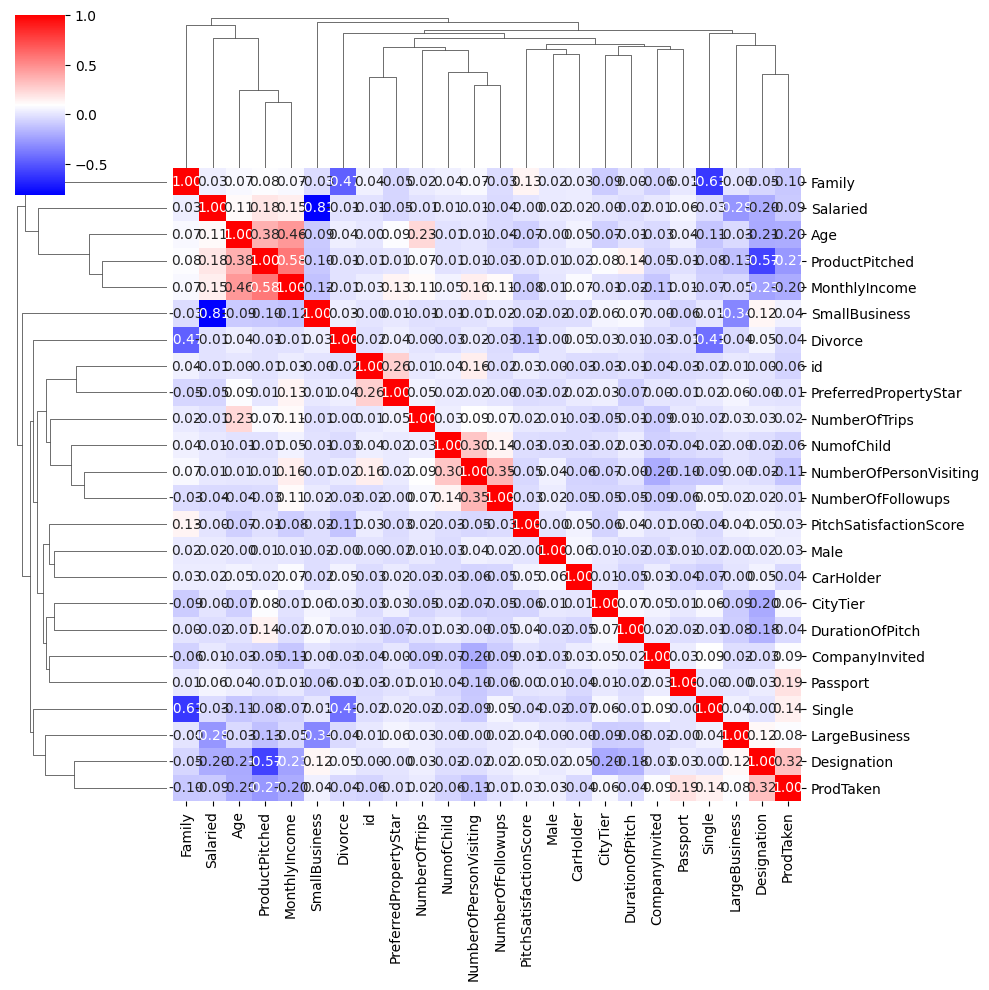

In [132]:
# 相関係数を確認する
import seaborn as sns
import matplotlib.pyplot as plt

all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [133]:
# "Salaried" と "SmallBusiness" が0.6 超えるため、サラリーマンかそうでないかに分ける
all_df = all_df.drop("SmallBusiness", axis=1)
all_df = all_df.drop("LargeBusiness", axis=1)

In [134]:
# "Family" と "Single" が0.6 超えるため、独身かそうでないかに分ける
all_df = all_df.drop("Family", axis=1)
all_df = all_df.drop("Divorce", axis=1)

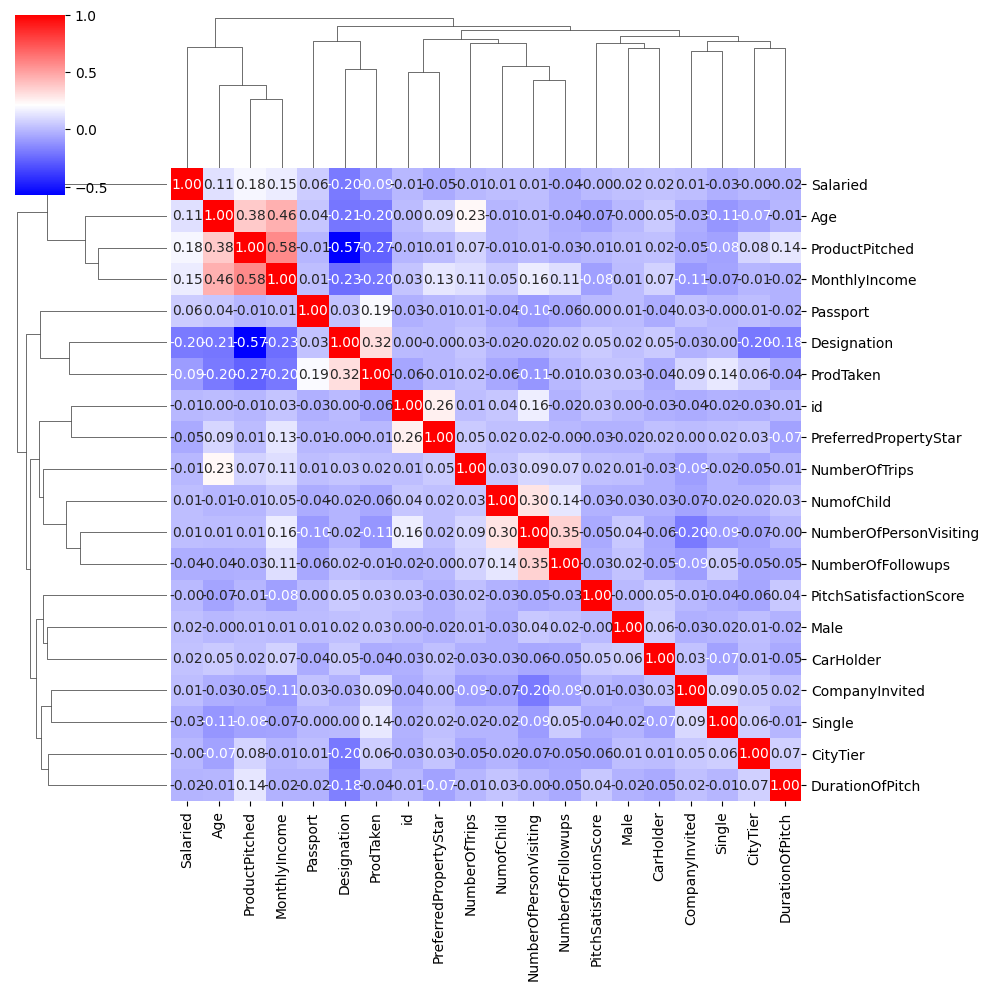

In [135]:
# 相関係数がすべて0.6未満に収まったので次のステップに進む
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# 特徴量エンジニアリング

In [71]:
plus = all_df[all_df["ProdTaken"]==1]

In [72]:
minus = all_df[all_df["ProdTaken"]==0]

In [ ]:
# 契約する人
# 若い(34.6歳 VS 40.2歳)、事業主(28.8% VS 42.0%)、パスポート(24.7% VS 7.9%)、月給(31.8万 VS 36.2万)、独身(52.1% VS 32.4%)

In [83]:
plus.describe()

,id,Age,CityTier,DurationOfPitch,Salaried,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,CarHolder,NumofChild,Single,ProdTaken
count,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.0
mean,1592.790744,34.625755,1.794769,0.863179,0.287726,2.193159,3.657948,1.432596,1.454728,0.247485,2.597586,318393.682093,0.323944,0.279678,0.521127,1.0
std,1014.825609,10.255643,0.646121,0.648659,0.453159,0.728809,0.884284,0.560803,0.752993,0.431986,1.017505,72018.519116,0.468450,0.585656,0.500057,0.0
min,0.000000,15.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,240000.000000,0.000000,0.000000,0.000000,1.0
25%,747.000000,26.000000,1.000000,0.000000,0.000000,2.000000,3.000000,1.000000,1.000000,0.000000,2.000000,262365.000000,0.000000,0.000000,0.000000,1.0
50%,1479.000000,33.000000,2.000000,1.000000,0.000000,2.000000,4.000000,1.000000,1.000000,0.000000,2.000000,300000.000000,0.000000,0.000000,1.000000,1.0
75%,2458.000000,40.000000,2.000000,1.000000,1.000000,3.000000,4.000000,2.000000,2.000000,0.000000,3.000000,349590.000000,1.000000,0.000000,1.000000,1.0
max,3487.000000,60.000000,3.000000,3.000000,1.000000,4.000000,6.000000,3.000000,3.000000,1.000000,5.000000,567900.000000,1.000000,2.000000,1.000000,1.0


In [84]:
minus.describe()

,id,Age,CityTier,DurationOfPitch,Salaried,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,MonthlyIncome,CarHolder,NumofChild,Single,ProdTaken
count,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.000000,2992.0
mean,1769.117313,40.188503,1.680816,0.953209,0.420455,2.428142,3.674465,1.442513,1.414773,0.078543,2.500000,361609.074198,0.384693,0.384358,0.323529,0.0
std,1004.048558,9.471873,0.674357,0.821690,0.493714,0.720932,0.885812,0.605920,0.674379,0.269069,1.130413,73221.537380,0.486604,0.667332,0.467901,0.0
min,1.000000,18.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,200000.000000,0.000000,0.000000,0.000000,0.0
25%,892.750000,34.000000,1.000000,0.000000,0.000000,2.000000,3.000000,1.000000,1.000000,0.000000,2.000000,310976.250000,0.000000,0.000000,0.000000,0.0
50%,1778.500000,39.000000,2.000000,1.000000,0.000000,2.000000,4.000000,1.000000,1.000000,0.000000,2.000000,347535.000000,0.000000,0.000000,0.000000,0.0
75%,2645.250000,47.000000,2.000000,1.000000,1.000000,3.000000,4.000000,2.000000,2.000000,0.000000,3.000000,400000.000000,1.000000,1.000000,1.000000,0.0
max,3488.000000,65.000000,3.000000,3.000000,1.000000,4.000000,6.000000,3.000000,3.000000,1.000000,5.000000,600000.000000,1.000000,3.000000,1.000000,0.0


In [81]:
plus[plus.columns].groupby("CompanyInvited").mean()

,id,Age,CityTier,DurationOfPitch,Salaried,Male,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,CarHolder,NumofChild,Single,ProdTaken
CompanyInvited,,,,,,,,,,,,,,,,,,,
0,1664.385496,35.278626,1.744275,0.828244,0.290076,0.194656,2.301527,3.706107,1.553435,1.450382,1.545802,0.221374,2.564885,4.148855,324446.965649,0.309160,0.324427,0.511450,1.0
1,1512.970213,33.897872,1.851064,0.902128,0.285106,0.153191,2.072340,3.604255,1.480851,1.412766,1.353191,0.276596,2.634043,4.123404,311644.914894,0.340426,0.229787,0.531915,1.0


In [82]:
minus[minus.columns].groupby("CompanyInvited").mean()

,id,Age,CityTier,DurationOfPitch,Salaried,Male,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,CarHolder,NumofChild,Single,ProdTaken
CompanyInvited,,,,,,,,,,,,,,,,,,,
0,1812.033024,40.195046,1.663571,0.946336,0.416409,0.151703,2.536636,3.737358,2.403509,1.449948,1.461816,0.076883,2.535088,2.692982,365821.916925,0.374613,0.418989,0.293086,0.0
1,1690.207780,40.176471,1.712524,0.965844,0.427894,0.12334,2.228653,3.558824,2.344402,1.428843,1.328273,0.081594,2.435484,2.511385,353862.879507,0.403226,0.320683,0.379507,0.0


In [ ]:
#-------------------------------------------------------------------------------------------
# カテゴリ列 x 13
# CompanyInvited, CityTier, DurationOfPitch, Salaried, Male, ProductPitched, PreferredPropertyStar,
# NumberOfTrips, Passport, PitchSatisfactionScore, Designation, CarHolder, Single
# 数値列 x 5
# Age, NumberOfPersonVisiting, NumberOfFollowups, MonthlyIncome, NumofChild
#-------------------------------------------------------------------------------------------
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken'],
      dtype='object')

In [ ]:
# 契約する人
# 若い(34.6歳 VS 40.2歳)、事業主(28.8% VS 42.0%)、パスポート(24.7% VS 7.9%)、月給(31.8万 VS 36.2万)、独身(52.1% VS 32.4%)

In [136]:
# クロス特徴量の追加
# (「独身」+「パスポート」) x 2
all_df["Single_Passport"] = (all_df["Single"] + all_df["Passport"]) * 2

# (「事業主」x「独身」) x 2
all_df["Business_Single"] = ((-all_df["Salaried"]+1) + all_df["Single"]) * 2

# (「月給」/「年齢」) x(「事業主」+1)
all_df["MonthlyIncome_Age_Business"] = all_df["MonthlyIncome"] / all_df["Age"] * (-all_df["Salaried"]+2)

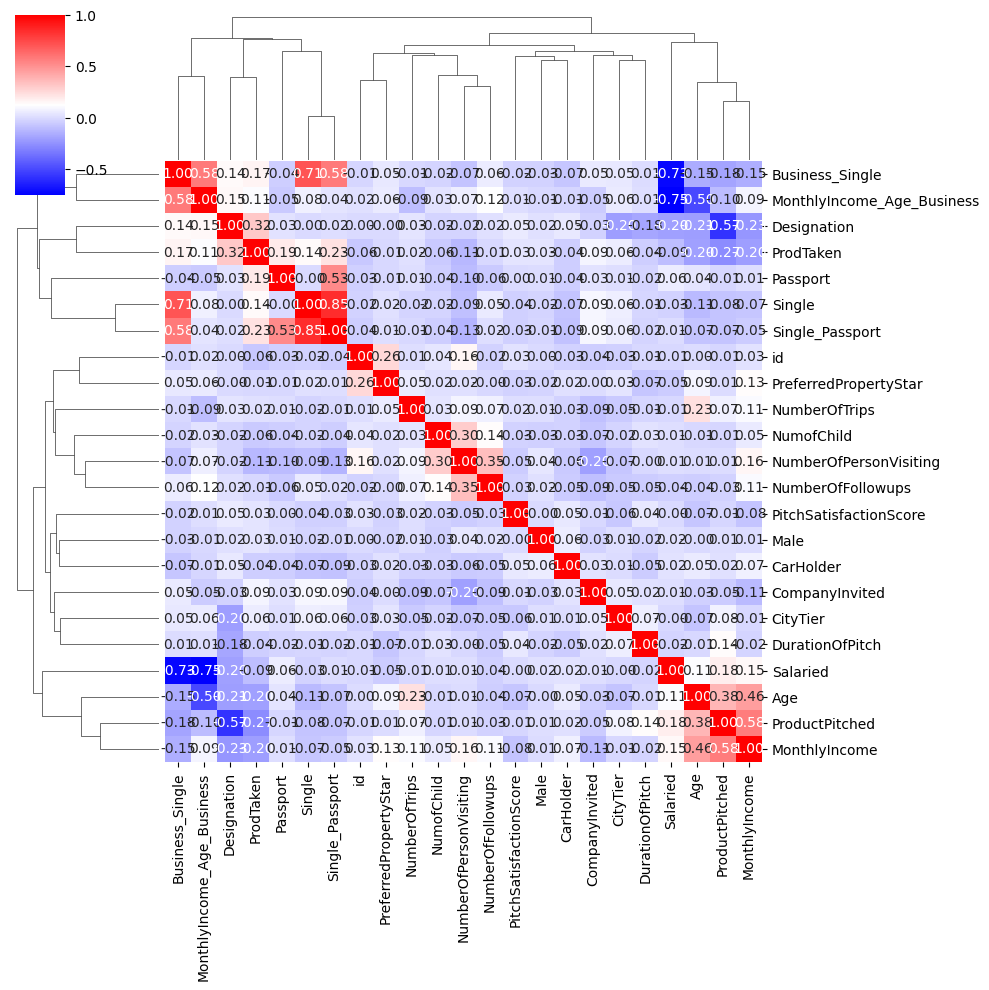

In [89]:
# 相関係数の確認OK
all_df_corr = all_df.corr()
sns.clustermap(all_df_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

In [90]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Salaried', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken', 'Single_Passport',
       'Business_Single', 'MonthlyIncome_Age_Business'],
      dtype='object')

In [ ]:
# 古い列を削除
# all_df = all_df.drop("Salaried", axis=1)

In [ ]:
# 順番を整列させる
col = ['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
       'Designation_ProductPitched', 'Male', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'CarHolder',
       'NumofChild', 'Single', 'ProdTaken']

all_df = all_df.reindex(columns=col)

In [101]:
all_df.columns

Index(['id', 'Age', 'CompanyInvited', 'CityTier', 'Salaried',
       'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched',
       'PreferredPropertyStar', 'Passport', 'PitchSatisfactionScore',
       'Designation', 'MonthlyIncome', 'CarHolder', 'NumofChild', 'Single',
       'ProdTaken', 'Single_Passport', 'Business_Single',
       'MonthlyIncome_Age_Business'],
      dtype='object')

In [146]:
all_df = all_df.drop("Male", axis=1)
all_df = all_df.drop("DurationOfPitch", axis=1)
all_df = all_df.drop("NumberOfTrips", axis=1)

In [ ]:
# 検討の結果、重要度が低いものを抹消する
# all_df = all_df.drop("Occupation_LE", axis=1)

In [ ]:
# 月収、年齢はLogを取る
# all_df["MonthlyIncomeLOG"] = np.log1p(all_df["MonthlyIncome"])
# all_df["AgeLOG"] = np.log1p(all_df["Age"])

# # 元の列削除
# all_df = all_df.drop("Age", axis=1)
# all_df = all_df.drop("MonthlyIncome", axis=1)

# ここから学習作業

In [147]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in all_df.columns if c not in RMV2]
TARGET = "ProdTaken"

In [148]:
CATS = []
for c in FEATURES:
  if all_df[c].dtype == "object":
    CATS.append(c)
print(CATS)

[]


In [149]:
# オブジェクト型はint型に変換する
all_df[CATS] = all_df[CATS].astype(int)

In [150]:
# カラムを制限
all_df2 = all_df[FEATURES]

# 結合を戻す
train = all_df2.iloc[:len(train_df)].copy()
test = all_df2.iloc[len(train_df):].reset_index(drop=True).copy()

# 対象の列のみ取り込み
test = test.drop(TARGET,axis=1)
FEATURES = test.columns

In [151]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

def objective(trial):

  lgbm_params = {
      'objective': 'binary',
      "device": "cpu",
      'metric': 'auc',
      'verbose': -1,              # ログ出力の制御
      'boosting_type': 'gbdt',
      'learning_rate': 0.1,

      'num_leaves': trial.suggest_int('num_leaves', 16, 256),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
      'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
      'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
      'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
      'max_depth': trial.suggest_int('max_depth', 3, 12),

      # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
      }

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

    # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    # x_test = test[FEATURES].copy()

    # データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              # lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

  score = roc_auc_score(train[TARGET],oof_lgb)

  return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2025-05-26 13:56:13,831] A new study created in memory with name: no-name-7357fae2-1b21-4b6f-961f-f7f9b5b89718
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.905917	valid's auc: 0.82457
#########################
### Fold 2
#########################


[I 2025-05-26 13:56:14,266] Trial 0 finished with value: 0.8205405561712521 and parameters: {'num_leaves': 27, 'min_data_in_leaf': 85, 'feature_fraction': 0.7006304770494052, 'bagging_fraction': 0.5108725658394676, 'bagging_freq': 2, 'lambda_l1': 2.4670960982657276e-05, 'lambda_l2': 1.9399339384811017e-07, 'max_depth': 5}. Best is trial 0 with value: 0.8205405561712521.


[100]	train's auc: 0.920069	valid's auc: 0.800836
#########################
### Fold 3
#########################
[100]	train's auc: 0.908065	valid's auc: 0.816111
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.992184	valid's auc: 0.806758
#########################
### Fold 2
#########################
[100]	train's auc: 0.994894	valid's auc: 0.759072
#########################
### Fold 3
#########################
[100]	train's auc: 0.992076	valid's auc: 0.795373


[I 2025-05-26 13:56:14,917] Trial 1 finished with value: 0.8075942284724389 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 31, 'feature_fraction': 0.7984238889737035, 'bagging_fraction': 0.6408379508515839, 'bagging_freq': 4, 'lambda_l1': 2.539806254211165e-07, 'lambda_l2': 1.2910578636468036e-07, 'max_depth': 11}. Best is trial 0 with value: 0.8205405561712521.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.925857	valid's auc: 0.830546
#########################
### Fold 2
#########################


[I 2025-05-26 13:56:15,372] Trial 2 finished with value: 0.8220395232356706 and parameters: {'num_leaves': 64, 'min_data_in_leaf': 99, 'feature_fraction': 0.6515024932217369, 'bagging_fraction': 0.8158360209516349, 'bagging_freq': 5, 'lambda_l1': 5.529419630952694e-05, 'lambda_l2': 0.7095714634401745, 'max_depth': 6}. Best is trial 2 with value: 0.8220395232356706.


[100]	train's auc: 0.937704	valid's auc: 0.79022
#########################
### Fold 3
#########################
[100]	train's auc: 0.930969	valid's auc: 0.807087
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.952735	valid's auc: 0.815108
#########################
### Fold 2
#########################
[100]	train's auc: 0.953073	valid's auc: 0.790317
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:15,890] Trial 3 finished with value: 0.8113002883611832 and parameters: {'num_leaves': 228, 'min_data_in_leaf': 48, 'feature_fraction': 0.6253085729857887, 'bagging_fraction': 0.5160304456143135, 'bagging_freq': 3, 'lambda_l1': 0.20559720557510722, 'lambda_l2': 1.4014800413239615e-06, 'max_depth': 10}. Best is trial 2 with value: 0.8220395232356706.


[100]	train's auc: 0.95726	valid's auc: 0.799217
#########################
### Fold 1
#########################
[100]	train's auc: 0.941253	valid's auc: 0.822806
#########################
### Fold 2
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
[I 2025-05-26 13:56:16,373] Trial 4 finished with value: 0.8193734600114053 and parameters: {'num_leaves': 248, 'min_data_in_leaf': 75, 'feature_fraction': 0.5934846780998638, 'bagging_fraction': 0.6581681470182599, 'bagging_freq': 7, 'lambda_l1': 2.1923273552153097e-05, 'lambda_l2': 0.0010669418602551875, 'max_depth': 8}. Best is trial 2 with value: 0.8220395232356706.


[100]	train's auc: 0.945532	valid's auc: 0.787876
#########################
### Fold 3
#########################
[100]	train's auc: 0.941128	valid's auc: 0.803935
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.972801	valid's auc: 0.813736
#########################
### Fold 2
#########################
[100]	train's auc: 0.976617	valid's auc: 0.781006


[I 2025-05-26 13:56:16,938] Trial 5 finished with value: 0.8017903544260214 and parameters: {'num_leaves': 41, 'min_data_in_leaf': 56, 'feature_fraction': 0.7071266411318147, 'bagging_fraction': 0.8816492970466476, 'bagging_freq': 5, 'lambda_l1': 5.381459455396412e-07, 'lambda_l2': 0.01933767706306748, 'max_depth': 7}. Best is trial 2 with value: 0.8220395232356706.


#########################
### Fold 3
#########################
[100]	train's auc: 0.975431	valid's auc: 0.796581
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.999514	valid's auc: 0.807066
#########################
### Fold 2
#########################
[100]	train's auc: 0.99987	valid's auc: 0.761677
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:17,661] Trial 6 finished with value: 0.7975089843876091 and parameters: {'num_leaves': 40, 'min_data_in_leaf': 13, 'feature_fraction': 0.655524985935674, 'bagging_fraction': 0.6154883753204726, 'bagging_freq': 1, 'lambda_l1': 0.07285143656118404, 'lambda_l2': 0.0005176695370700575, 'max_depth': 11}. Best is trial 2 with value: 0.8220395232356706.


[100]	train's auc: 0.999418	valid's auc: 0.769782
#########################
### Fold 1
#########################
[100]	train's auc: 0.959474	valid's auc: 0.820208


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.96296	valid's auc: 0.79387


[I 2025-05-26 13:56:18,228] Trial 7 finished with value: 0.7990076152099763 and parameters: {'num_leaves': 222, 'min_data_in_leaf': 72, 'feature_fraction': 0.6842426451982934, 'bagging_fraction': 0.7559493644417921, 'bagging_freq': 7, 'lambda_l1': 1.0409828699679098e-07, 'lambda_l2': 4.805867365456696e-08, 'max_depth': 11}. Best is trial 2 with value: 0.8220395232356706.


#########################
### Fold 3
#########################
[100]	train's auc: 0.962605	valid's auc: 0.799678
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.870468	valid's auc: 0.833422
#########################
### Fold 2
#########################
[100]	train's auc: 0.881323	valid's auc: 0.801126


[I 2025-05-26 13:56:18,700] Trial 8 finished with value: 0.8212016080439858 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 92, 'feature_fraction': 0.5438717519320286, 'bagging_fraction': 0.5618702072320159, 'bagging_freq': 6, 'lambda_l1': 0.01081540804744703, 'lambda_l2': 5.481340324788732, 'max_depth': 3}. Best is trial 2 with value: 0.8220395232356706.


#########################
### Fold 3
#########################
[100]	train's auc: 0.874498	valid's auc: 0.819566
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.930162	valid's auc: 0.832781
#########################
### Fold 2
#########################
[100]	train's auc: 0.94134	valid's auc: 0.79706


[I 2025-05-26 13:56:19,225] Trial 9 finished with value: 0.8121651029169672 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 79, 'feature_fraction': 0.8494144311427934, 'bagging_fraction': 0.5987597498913091, 'bagging_freq': 2, 'lambda_l1': 3.4953905952355627e-06, 'lambda_l2': 0.38900604982383247, 'max_depth': 9}. Best is trial 2 with value: 0.8220395232356706.


#########################
### Fold 3
#########################
[100]	train's auc: 0.936887	valid's auc: 0.807712
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.962112	valid's auc: 0.819386
#########################
### Fold 2
#########################
[100]	train's auc: 0.970579	valid's auc: 0.778528
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:19,781] Trial 10 finished with value: 0.8126573612799793 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 56, 'feature_fraction': 0.9980824348098689, 'bagging_fraction': 0.9805807523109373, 'bagging_freq': 5, 'lambda_l1': 0.0006733638976241311, 'lambda_l2': 3.438591460595266e-05, 'max_depth': 6}. Best is trial 2 with value: 0.8220395232356706.


[100]	train's auc: 0.97237	valid's auc: 0.788553
#########################
### Fold 1
#########################
[100]	train's auc: 0.879134	valid's auc: 0.838748


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.891938	valid's auc: 0.800558
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:20,312] Trial 11 finished with value: 0.8240704252251477 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 98, 'feature_fraction': 0.5050979991262623, 'bagging_fraction': 0.7891254564024937, 'bagging_freq': 6, 'lambda_l1': 0.001568833938620603, 'lambda_l2': 2.6668785224080898, 'max_depth': 3}. Best is trial 11 with value: 0.8240704252251477.


[100]	train's auc: 0.886482	valid's auc: 0.819919
#########################
### Fold 1
#########################
[100]	train's auc: 0.862095	valid's auc: 0.841428


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.877581	valid's auc: 0.80428
[200]	train's auc: 0.889376	valid's auc: 0.805005
[300]	train's auc: 0.899708	valid's auc: 0.804552
#########################
### Fold 3
#########################
[100]	train's auc: 0.866279	valid's auc: 0.825824


[I 2025-05-26 13:56:23,647] Trial 12 finished with value: 0.8212110228214203 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 100, 'feature_fraction': 0.5124012079446537, 'bagging_fraction': 0.792261957473804, 'bagging_freq': 5, 'lambda_l1': 3.2882911307039207, 'lambda_l2': 8.661286817210817, 'max_depth': 3}. Best is trial 11 with value: 0.8240704252251477.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.917487	valid's auc: 0.830679
#########################
### Fold 2
#########################
[100]	train's auc: 0.929293	valid's auc: 0.797845
#########################
### Fold 3
#########################
[100]	train's auc: 0.925123	valid's auc: 0.80951


[I 2025-05-26 13:56:24,190] Trial 13 finished with value: 0.8226034011555966 and parameters: {'num_leaves': 178, 'min_data_in_leaf': 99, 'feature_fraction': 0.5719493469610926, 'bagging_fraction': 0.8492039366539871, 'bagging_freq': 6, 'lambda_l1': 0.0007904246697526889, 'lambda_l2': 0.09590325969072579, 'max_depth': 5}. Best is trial 11 with value: 0.8240704252251477.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.917816	valid's auc: 0.835108
#########################
### Fold 2
#########################


[I 2025-05-26 13:56:24,695] Trial 14 finished with value: 0.8220966843843812 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 65, 'feature_fraction': 0.5014161203888695, 'bagging_fraction': 0.8815591704638821, 'bagging_freq': 6, 'lambda_l1': 0.0020186941924990247, 'lambda_l2': 0.026702334060890245, 'max_depth': 4}. Best is trial 11 with value: 0.8240704252251477.


[100]	train's auc: 0.92599	valid's auc: 0.78871
#########################
### Fold 3
#########################
[100]	train's auc: 0.925791	valid's auc: 0.817241


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.916601	valid's auc: 0.830727
#########################
### Fold 2
#########################
[100]	train's auc: 0.925503	valid's auc: 0.792776
#########################
### Fold 3
#########################
[100]	train's auc: 0.921144	valid's auc: 0.814228


[I 2025-05-26 13:56:25,224] Trial 15 finished with value: 0.8211071240275879 and parameters: {'num_leaves': 183, 'min_data_in_leaf': 88, 'feature_fraction': 0.5758325347152086, 'bagging_fraction': 0.707688389426881, 'bagging_freq': 6, 'lambda_l1': 0.007079740992200106, 'lambda_l2': 0.07913238901086829, 'max_depth': 5}. Best is trial 11 with value: 0.8240704252251477.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.934409	valid's auc: 0.827954
#########################
### Fold 2
#########################


[I 2025-05-26 13:56:25,707] Trial 16 finished with value: 0.8178358251110944 and parameters: {'num_leaves': 125, 'min_data_in_leaf': 42, 'feature_fraction': 0.776329579922607, 'bagging_fraction': 0.8909261125610831, 'bagging_freq': 7, 'lambda_l1': 0.00024995969613463074, 'lambda_l2': 0.005543284898702367, 'max_depth': 4}. Best is trial 11 with value: 0.8240704252251477.


[100]	train's auc: 0.941022	valid's auc: 0.781374
#########################
### Fold 3
#########################
[100]	train's auc: 0.942001	valid's auc: 0.80453


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.924769	valid's auc: 0.83005
#########################
### Fold 2
#########################


[I 2025-05-26 13:56:26,166] Trial 17 finished with value: 0.8188596821571138 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 67, 'feature_fraction': 0.8993662635042533, 'bagging_fraction': 0.983333061726018, 'bagging_freq': 4, 'lambda_l1': 0.267644325395953, 'lambda_l2': 4.186686688660331e-05, 'max_depth': 4}. Best is trial 11 with value: 0.8240704252251477.


[100]	train's auc: 0.930897	valid's auc: 0.787386
#########################
### Fold 3
#########################
[100]	train's auc: 0.930765	valid's auc: 0.801184


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.925369	valid's auc: 0.825972
#########################
### Fold 2
#########################


[I 2025-05-26 13:56:26,705] Trial 18 finished with value: 0.819610510657528 and parameters: {'num_leaves': 194, 'min_data_in_leaf': 89, 'feature_fraction': 0.5605168217889963, 'bagging_fraction': 0.8296072012045239, 'bagging_freq': 6, 'lambda_l1': 0.020989498859202316, 'lambda_l2': 0.8096072803792882, 'max_depth': 6}. Best is trial 11 with value: 0.8240704252251477.


[100]	train's auc: 0.94074	valid's auc: 0.79254
#########################
### Fold 3
#########################
[100]	train's auc: 0.935309	valid's auc: 0.809771


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.86165	valid's auc: 0.839325
[200]	train's auc: 0.878445	valid's auc: 0.838576
#########################
### Fold 2
#########################
[100]	train's auc: 0.87729	valid's auc: 0.804885
[200]	train's auc: 0.892099	valid's auc: 0.806014
[300]	train's auc: 0.899725	valid's auc: 0.804897
#########################
### Fold 3
#########################
[100]	train's auc: 0.868557	valid's auc: 0.828144


[I 2025-05-26 13:56:27,601] Trial 19 finished with value: 0.823994434521568 and parameters: {'num_leaves': 93, 'min_data_in_leaf': 100, 'feature_fraction': 0.6092217714709396, 'bagging_fraction': 0.7169197051209444, 'bagging_freq': 3, 'lambda_l1': 4.886431624845881, 'lambda_l2': 0.2765393995176397, 'max_depth': 3}. Best is trial 11 with value: 0.8240704252251477.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.865111	valid's auc: 0.840727
#########################
### Fold 2
#########################
[100]	train's auc: 0.879474	valid's auc: 0.803199
[200]	train's auc: 0.896315	valid's auc: 0.803658
[300]	train's auc: 0.906039	valid's auc: 0.803767
#########################
### Fold 3
#########################
[100]	train's auc: 0.871465	valid's auc: 0.82638


[I 2025-05-26 13:56:28,412] Trial 20 finished with value: 0.8220344796049021 and parameters: {'num_leaves': 81, 'min_data_in_leaf': 81, 'feature_fraction': 0.6240290735328753, 'bagging_fraction': 0.6988453365380722, 'bagging_freq': 3, 'lambda_l1': 4.033056912950941, 'lambda_l2': 2.5587756403678905, 'max_depth': 3}. Best is trial 11 with value: 0.8240704252251477.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.898052	valid's auc: 0.838274
#########################
### Fold 2
#########################


[I 2025-05-26 13:56:28,943] Trial 21 finished with value: 0.8248276423245354 and parameters: {'num_leaves': 109, 'min_data_in_leaf': 100, 'feature_fraction': 0.5399733985372649, 'bagging_fraction': 0.7441261006147926, 'bagging_freq': 4, 'lambda_l1': 1.2463445017659067, 'lambda_l2': 0.13768709225018477, 'max_depth': 5}. Best is trial 21 with value: 0.8248276423245354.


[100]	train's auc: 0.907983	valid's auc: 0.799018
#########################
### Fold 3
#########################
[100]	train's auc: 0.905063	valid's auc: 0.819002


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.883827	valid's auc: 0.835845
#########################
### Fold 2
#########################
[100]	train's auc: 0.895012	valid's auc: 0.801863
#########################
### Fold 3
#########################
[100]	train's auc: 0.885337	valid's auc: 0.824777


[I 2025-05-26 13:56:29,449] Trial 22 finished with value: 0.8236178434241815 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 93, 'feature_fraction': 0.5338034283777173, 'bagging_fraction': 0.7500760221706716, 'bagging_freq': 3, 'lambda_l1': 0.6499811746443331, 'lambda_l2': 0.0039983499825545655, 'max_depth': 3}. Best is trial 21 with value: 0.8248276423245354.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.849837	valid's auc: 0.841573
[200]	train's auc: 0.855833	valid's auc: 0.842679
#########################
### Fold 2
#########################
[100]	train's auc: 0.868906	valid's auc: 0.801374
[200]	train's auc: 0.875379	valid's auc: 0.805875
[300]	train's auc: 0.879389	valid's auc: 0.808866
[400]	train's auc: 0.882039	valid's auc: 0.808341
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:30,327] Trial 23 finished with value: 0.8245418365809832 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 94, 'feature_fraction': 0.5029826444491453, 'bagging_fraction': 0.699443584079393, 'bagging_freq': 4, 'lambda_l1': 8.420623420621133, 'lambda_l2': 0.1510040104299226, 'max_depth': 4}. Best is trial 21 with value: 0.8248276423245354.


[100]	train's auc: 0.856859	valid's auc: 0.83262
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.892682	valid's auc: 0.834189
#########################
### Fold 2
#########################
[100]	train's auc: 0.905513	valid's auc: 0.795296
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:30,812] Trial 24 finished with value: 0.8192668712811628 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 84, 'feature_fraction': 0.5161661160019495, 'bagging_fraction': 0.6767368626184738, 'bagging_freq': 4, 'lambda_l1': 0.38280409620187184, 'lambda_l2': 1.7050905181448013, 'max_depth': 4}. Best is trial 21 with value: 0.8248276423245354.


[100]	train's auc: 0.897202	valid's auc: 0.819245
#########################
### Fold 1
#########################
[100]	train's auc: 0.848712	valid's auc: 0.841875


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.853571	valid's auc: 0.839754
#########################
### Fold 2
#########################
[100]	train's auc: 0.866968	valid's auc: 0.801727
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:31,485] Trial 25 finished with value: 0.8237984054056962 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 94, 'feature_fraction': 0.5413618961817953, 'bagging_fraction': 0.7777653086962326, 'bagging_freq': 4, 'lambda_l1': 9.646612907419934, 'lambda_l2': 0.09929949890801108, 'max_depth': 7}. Best is trial 21 with value: 0.8248276423245354.


[100]	train's auc: 0.854562	valid's auc: 0.830209
[200]	train's auc: 0.858151	valid's auc: 0.830561
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.952876	valid's auc: 0.828908
#########################
### Fold 2
#########################
[100]	train's auc: 0.956762	valid's auc: 0.788558
#########################
### Fold 3
#########################
[100]	train's auc: 0.961807	valid's auc: 0.802957


[I 2025-05-26 13:56:32,092] Trial 26 finished with value: 0.8164616038476851 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 13, 'feature_fraction': 0.5016772134928914, 'bagging_fraction': 0.7277046376329744, 'bagging_freq': 4, 'lambda_l1': 1.2413484743567933, 'lambda_l2': 3.3619284837754055e-05, 'max_depth': 5}. Best is trial 21 with value: 0.8248276423245354.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.911184	valid's auc: 0.830582
#########################
### Fold 2
#########################


[I 2025-05-26 13:56:32,607] Trial 27 finished with value: 0.8221195488438653 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 75, 'feature_fraction': 0.5742808742212594, 'bagging_fraction': 0.7895194901302656, 'bagging_freq': 5, 'lambda_l1': 0.10397421886202365, 'lambda_l2': 0.011420302293761543, 'max_depth': 4}. Best is trial 21 with value: 0.8248276423245354.


[100]	train's auc: 0.921352	valid's auc: 0.79761
#########################
### Fold 3
#########################
[100]	train's auc: 0.915258	valid's auc: 0.809893


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.957298	valid's auc: 0.815851
#########################
### Fold 2
#########################


[I 2025-05-26 13:56:33,114] Trial 28 finished with value: 0.8002870162149367 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 65, 'feature_fraction': 0.9979450287551492, 'bagging_fraction': 0.9411149387123963, 'bagging_freq': 2, 'lambda_l1': 0.04391226467584851, 'lambda_l2': 0.0012953927905357274, 'max_depth': 6}. Best is trial 21 with value: 0.8248276423245354.


[100]	train's auc: 0.966112	valid's auc: 0.782244
#########################
### Fold 3
#########################
[100]	train's auc: 0.964836	valid's auc: 0.785316


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.896315	valid's auc: 0.836413
#########################
### Fold 2
#########################


[I 2025-05-26 13:56:36,210] Trial 29 finished with value: 0.8104226966074523 and parameters: {'num_leaves': 17, 'min_data_in_leaf': 85, 'feature_fraction': 0.7287635588120598, 'bagging_fraction': 0.7461802360655849, 'bagging_freq': 3, 'lambda_l1': 0.004533413830290853, 'lambda_l2': 9.234503540159405, 'max_depth': 5}. Best is trial 21 with value: 0.8248276423245354.


[100]	train's auc: 0.907695	valid's auc: 0.798021
#########################
### Fold 3
#########################
[100]	train's auc: 0.904303	valid's auc: 0.814007


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.946775	valid's auc: 0.816419
#########################
### Fold 2
#########################


[I 2025-05-26 13:56:36,764] Trial 30 finished with value: 0.8137639338706033 and parameters: {'num_leaves': 48, 'min_data_in_leaf': 31, 'feature_fraction': 0.6563558374411139, 'bagging_fraction': 0.5827162412811604, 'bagging_freq': 4, 'lambda_l1': 2.1054015481800347e-08, 'lambda_l2': 1.5160303075026983e-06, 'max_depth': 5}. Best is trial 21 with value: 0.8248276423245354.


[100]	train's auc: 0.95549	valid's auc: 0.779471
#########################
### Fold 3
#########################
[100]	train's auc: 0.954541	valid's auc: 0.791747


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.871172	valid's auc: 0.840401
[200]	train's auc: 0.894357	valid's auc: 0.830365
#########################
### Fold 2
#########################


[I 2025-05-26 13:56:37,298] Trial 31 finished with value: 0.8216656220746943 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 95, 'feature_fraction': 0.6023758867077937, 'bagging_fraction': 0.6919541211022204, 'bagging_freq': 3, 'lambda_l1': 2.401226930725984, 'lambda_l2': 0.24746505927391893, 'max_depth': 3}. Best is trial 21 with value: 0.8248276423245354.


[100]	train's auc: 0.886155	valid's auc: 0.801277
#########################
### Fold 3
#########################
[100]	train's auc: 0.879291	valid's auc: 0.822903


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.852612	valid's auc: 0.847222
[200]	train's auc: 0.862499	valid's auc: 0.847144
#########################
### Fold 2
#########################
[100]	train's auc: 0.871532	valid's auc: 0.806951
[200]	train's auc: 0.878719	valid's auc: 0.80686
[300]	train's auc: 0.885316	valid's auc: 0.808051
[400]	train's auc: 0.889864	valid's auc: 0.808486
#########################
### Fold 3
#########################
[100]	train's auc: 0.860213	valid's auc: 0.829905


[I 2025-05-26 13:56:38,551] Trial 32 finished with value: 0.8267559904883849 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 89, 'feature_fraction': 0.5405620114809089, 'bagging_fraction': 0.6303255807621366, 'bagging_freq': 1, 'lambda_l1': 7.2170106090074535, 'lambda_l2': 0.17839017076845926, 'max_depth': 4}. Best is trial 32 with value: 0.8267559904883849.


[200]	train's auc: 0.870893	valid's auc: 0.830667
[300]	train's auc: 0.876311	valid's auc: 0.83054
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.882525	valid's auc: 0.839748
#########################
### Fold 2
#########################
[100]	train's auc: 0.895711	valid's auc: 0.803622


[I 2025-05-26 13:56:39,131] Trial 33 finished with value: 0.8245885742261052 and parameters: {'num_leaves': 74, 'min_data_in_leaf': 87, 'feature_fraction': 0.541028740798754, 'bagging_fraction': 0.5520215080737481, 'bagging_freq': 1, 'lambda_l1': 1.2168077512168192, 'lambda_l2': 1.8234514423829624, 'max_depth': 4}. Best is trial 32 with value: 0.8267559904883849.


#########################
### Fold 3
#########################
[100]	train's auc: 0.888778	valid's auc: 0.825627
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.880547	valid's auc: 0.836781
#########################
### Fold 2
#########################
[100]	train's auc: 0.894647	valid's auc: 0.803265
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:39,592] Trial 34 finished with value: 0.8218935941854334 and parameters: {'num_leaves': 70, 'min_data_in_leaf': 88, 'feature_fraction': 0.5573152082633788, 'bagging_fraction': 0.5327292498838484, 'bagging_freq': 2, 'lambda_l1': 1.7002613468388326, 'lambda_l2': 0.061164313369143714, 'max_depth': 4}. Best is trial 32 with value: 0.8267559904883849.


[100]	train's auc: 0.886438	valid's auc: 0.820532
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.844739	valid's auc: 0.843893
[200]	train's auc: 0.85144	valid's auc: 0.843222
#########################
### Fold 2
#########################
[100]	train's auc: 0.863639	valid's auc: 0.804528
[200]	train's auc: 0.868538	valid's auc: 0.805459
[300]	train's auc: 0.87333	valid's auc: 0.807519
[400]	train's auc: 0.876708	valid's auc: 0.807066
#########################
### Fold 3
#########################
[100]	train's auc: 0.854734	valid's auc: 0.829744
[200]	train's auc: 0.861799	valid's auc: 0.830443
[300]	train's auc: 0.865787	valid's auc: 0.830382
[400]	train's auc: 0.867897	valid's auc: 0.830953


[I 2025-05-26 13:56:40,667] Trial 35 finished with value: 0.8250048418855379 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 84, 'feature_fraction': 0.5335958475219776, 'bagging_fraction': 0.6489229898122446, 'bagging_freq': 1, 'lambda_l1': 9.19741005897503, 'lambda_l2': 0.8920406333080351, 'max_depth': 7}. Best is trial 32 with value: 0.8267559904883849.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.919023	valid's auc: 0.828836
#########################
### Fold 2
#########################


[I 2025-05-26 13:56:41,151] Trial 36 finished with value: 0.822608108544314 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 79, 'feature_fraction': 0.6359880718905893, 'bagging_fraction': 0.6371759737703423, 'bagging_freq': 1, 'lambda_l1': 0.7691286443734735, 'lambda_l2': 0.5750963123793756, 'max_depth': 8}. Best is trial 32 with value: 0.8267559904883849.


[100]	train's auc: 0.932628	valid's auc: 0.796202
#########################
### Fold 3
#########################
[100]	train's auc: 0.921365	valid's auc: 0.810597


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.907133	valid's auc: 0.835023
#########################
### Fold 2
#########################
[100]	train's auc: 0.919098	valid's auc: 0.798528
#########################
### Fold 3
#########################
[100]	train's auc: 0.913741	valid's auc: 0.82621


[I 2025-05-26 13:56:41,705] Trial 37 finished with value: 0.8208189645896772 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 82, 'feature_fraction': 0.6822355998472966, 'bagging_fraction': 0.5353773408468508, 'bagging_freq': 1, 'lambda_l1': 0.1819793220207797, 'lambda_l2': 1.4127037365818078, 'max_depth': 7}. Best is trial 32 with value: 0.8267559904883849.


[200]	train's auc: 0.9473	valid's auc: 0.806449
#########################
### Fold 1
#########################
[100]	train's auc: 0.925292	valid's auc: 0.828111


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.939585	valid's auc: 0.796546
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:42,197] Trial 38 finished with value: 0.8195812575990704 and parameters: {'num_leaves': 52, 'min_data_in_leaf': 68, 'feature_fraction': 0.6002846747716271, 'bagging_fraction': 0.6393292860709281, 'bagging_freq': 1, 'lambda_l1': 1.0794563059070017, 'lambda_l2': 0.03124720592568653, 'max_depth': 9}. Best is trial 32 with value: 0.8267559904883849.


[100]	train's auc: 0.932835	valid's auc: 0.806504
#########################
### Fold 1
#########################
[100]	train's auc: 0.927018	valid's auc: 0.82854


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.940293	valid's auc: 0.796963
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:42,721] Trial 39 finished with value: 0.8215250728972767 and parameters: {'num_leaves': 38, 'min_data_in_leaf': 73, 'feature_fraction': 0.5404745121716129, 'bagging_fraction': 0.5671188241602605, 'bagging_freq': 2, 'lambda_l1': 0.048587203803390454, 'lambda_l2': 0.00016709138982202483, 'max_depth': 8}. Best is trial 32 with value: 0.8267559904883849.


[100]	train's auc: 0.933054	valid's auc: 0.807354
#########################
### Fold 1
#########################
[100]	train's auc: 0.843649	valid's auc: 0.843954


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.849271	valid's auc: 0.843488
#########################
### Fold 2
#########################
[100]	train's auc: 0.862896	valid's auc: 0.804752
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:43,344] Trial 40 finished with value: 0.8239577841379829 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 48, 'feature_fraction': 0.5842676857594604, 'bagging_fraction': 0.5015479973397052, 'bagging_freq': 1, 'lambda_l1': 9.684729807891339, 'lambda_l2': 0.7341045367119997, 'max_depth': 6}. Best is trial 32 with value: 0.8267559904883849.


[100]	train's auc: 0.852776	valid's auc: 0.829489
[200]	train's auc: 0.859904	valid's auc: 0.830935
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.866328	valid's auc: 0.843129
#########################
### Fold 2
#########################
[100]	train's auc: 0.880564	valid's auc: 0.803737
[200]	train's auc: 0.896784	valid's auc: 0.801894
#########################
### Fold 3
#########################
[100]	train's auc: 0.87326	valid's auc: 0.82635


[I 2025-05-26 13:56:44,005] Trial 41 finished with value: 0.8228932418037639 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 90, 'feature_fraction': 0.5304998282725112, 'bagging_fraction': 0.6184949229277071, 'bagging_freq': 2, 'lambda_l1': 4.648772109609294, 'lambda_l2': 0.20850606238145766, 'max_depth': 12}. Best is trial 32 with value: 0.8267559904883849.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.890274	valid's auc: 0.835621
#########################
### Fold 2
#########################
[100]	train's auc: 0.903881	valid's auc: 0.804921
#########################
### Fold 3
#########################
[100]	train's auc: 0.895246	valid's auc: 0.823933


[I 2025-05-26 13:56:44,588] Trial 42 finished with value: 0.8238885182754279 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 86, 'feature_fraction': 0.5586630379465857, 'bagging_fraction': 0.6607967795002687, 'bagging_freq': 1, 'lambda_l1': 0.5908660986563602, 'lambda_l2': 2.8579450145178775, 'max_depth': 4}. Best is trial 32 with value: 0.8267559904883849.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.846461	valid's auc: 0.846277
[200]	train's auc: 0.852821	valid's auc: 0.846373
#########################
### Fold 2
#########################
[100]	train's auc: 0.86464	valid's auc: 0.806111


[I 2025-05-26 13:56:45,299] Trial 43 finished with value: 0.8252950187757561 and parameters: {'num_leaves': 128, 'min_data_in_leaf': 96, 'feature_fraction': 0.5255228791970291, 'bagging_fraction': 0.6716346769324779, 'bagging_freq': 1, 'lambda_l1': 8.966069865221623, 'lambda_l2': 0.006355926497030426, 'max_depth': 5}. Best is trial 32 with value: 0.8267559904883849.


#########################
### Fold 3
#########################
[100]	train's auc: 0.85333	valid's auc: 0.828342
[200]	train's auc: 0.860961	valid's auc: 0.827637


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.894428	valid's auc: 0.835452
#########################
### Fold 2
#########################
[100]	train's auc: 0.907153	valid's auc: 0.80422
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:45,918] Trial 44 finished with value: 0.8193505955519211 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 96, 'feature_fraction': 0.8233244223441618, 'bagging_fraction': 0.6035500391999972, 'bagging_freq': 1, 'lambda_l1': 2.086190706850687, 'lambda_l2': 0.008805642857053835, 'max_depth': 7}. Best is trial 32 with value: 0.8267559904883849.


[100]	train's auc: 0.899442	valid's auc: 0.817143
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.920205	valid's auc: 0.832322
#########################
### Fold 2
#########################
[100]	train's auc: 0.935148	valid's auc: 0.800468
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:48,959] Trial 45 finished with value: 0.8230922970980966 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 78, 'feature_fraction': 0.6282916195095056, 'bagging_fraction': 0.6614591569425964, 'bagging_freq': 1, 'lambda_l1': 5.346876068894431e-06, 'lambda_l2': 0.0017689834244210406, 'max_depth': 5}. Best is trial 32 with value: 0.8267559904883849.


[100]	train's auc: 0.929073	valid's auc: 0.81203
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.933816	valid's auc: 0.830896
#########################
### Fold 2
#########################
[100]	train's auc: 0.947129	valid's auc: 0.78741


[I 2025-05-26 13:56:49,503] Trial 46 finished with value: 0.8195590656236886 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 60, 'feature_fraction': 0.5383299846040431, 'bagging_fraction': 0.620403277525362, 'bagging_freq': 2, 'lambda_l1': 0.19891625354013906, 'lambda_l2': 0.03669060866671902, 'max_depth': 6}. Best is trial 32 with value: 0.8267559904883849.


#########################
### Fold 3
#########################
[100]	train's auc: 0.93952	valid's auc: 0.807627
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.89255	valid's auc: 0.834213
#########################
### Fold 2
#########################
[100]	train's auc: 0.903957	valid's auc: 0.79967
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:49,992] Trial 47 finished with value: 0.8183590177428206 and parameters: {'num_leaves': 71, 'min_data_in_leaf': 85, 'feature_fraction': 0.5914168877208525, 'bagging_fraction': 0.5542776539777782, 'bagging_freq': 2, 'lambda_l1': 1.912784042171238, 'lambda_l2': 0.015357560052447008, 'max_depth': 9}. Best is trial 32 with value: 0.8267559904883849.


[100]	train's auc: 0.89724	valid's auc: 0.81523
#########################
### Fold 1
#########################
[100]	train's auc: 0.904318	valid's auc: 0.830522


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.917433	valid's auc: 0.806184
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:50,568] Trial 48 finished with value: 0.8230865809832254 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 93, 'feature_fraction': 0.5276724986416997, 'bagging_fraction': 0.5868901447144439, 'bagging_freq': 1, 'lambda_l1': 0.00010910188237507582, 'lambda_l2': 0.00039142380467585157, 'max_depth': 5}. Best is trial 32 with value: 0.8267559904883849.


[100]	train's auc: 0.90992	valid's auc: 0.811951
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.905427	valid's auc: 0.83109
#########################
### Fold 2
#########################
[100]	train's auc: 0.914719	valid's auc: 0.803537
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:51,176] Trial 49 finished with value: 0.8215321339803526 and parameters: {'num_leaves': 27, 'min_data_in_leaf': 90, 'feature_fraction': 0.6678122816377817, 'bagging_fraction': 0.6771744221668156, 'bagging_freq': 1, 'lambda_l1': 0.5038457106502285, 'lambda_l2': 4.051005834937953, 'max_depth': 10}. Best is trial 32 with value: 0.8267559904883849.


[100]	train's auc: 0.911578	valid's auc: 0.815771
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.91839	valid's auc: 0.829525
#########################
### Fold 2
#########################
[100]	train's auc: 0.929537	valid's auc: 0.79309


[I 2025-05-26 13:56:51,749] Trial 50 finished with value: 0.821025080967086 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 97, 'feature_fraction': 0.5586727459142441, 'bagging_fraction': 0.7340020640547444, 'bagging_freq': 2, 'lambda_l1': 0.018947531443681723, 'lambda_l2': 0.6371776736343947, 'max_depth': 6}. Best is trial 32 with value: 0.8267559904883849.


#########################
### Fold 3
#########################
[100]	train's auc: 0.9194	valid's auc: 0.814107


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.847878	valid's auc: 0.846241
[200]	train's auc: 0.854774	valid's auc: 0.846334
#########################
### Fold 2
#########################
[100]	train's auc: 0.86596	valid's auc: 0.807579
#########################
### Fold 3
#########################
[100]	train's auc: 0.855629	valid's auc: 0.829574


[I 2025-05-26 13:56:52,517] Trial 51 finished with value: 0.8265471841745662 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 92, 'feature_fraction': 0.5147351681338773, 'bagging_fraction': 0.678628006825178, 'bagging_freq': 1, 'lambda_l1': 8.521690416943548, 'lambda_l2': 0.11264705764846071, 'max_depth': 4}. Best is trial 32 with value: 0.8267559904883849.


[200]	train's auc: 0.864212	valid's auc: 0.828226
#########################
### Fold 1
#########################
[100]	train's auc: 0.862894	valid's auc: 0.845621


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.879296	valid's auc: 0.842256
#########################
### Fold 2
#########################
[100]	train's auc: 0.879602	valid's auc: 0.810468
#########################
### Fold 3
#########################
[100]	train's auc: 0.870244	valid's auc: 0.826744


[I 2025-05-26 13:56:53,220] Trial 52 finished with value: 0.827140651395001 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 100, 'feature_fraction': 0.5177107796534037, 'bagging_fraction': 0.6303344062029703, 'bagging_freq': 1, 'lambda_l1': 4.553261833442069, 'lambda_l2': 0.05172963615522315, 'max_depth': 4}. Best is trial 52 with value: 0.827140651395001.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.864783	valid's auc: 0.844479
[200]	train's auc: 0.881483	valid's auc: 0.84344
#########################
### Fold 2
#########################
[100]	train's auc: 0.881396	valid's auc: 0.810836


[I 2025-05-26 13:56:53,899] Trial 53 finished with value: 0.8272206770031956 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 100, 'feature_fraction': 0.519019603165178, 'bagging_fraction': 0.6471849172183962, 'bagging_freq': 1, 'lambda_l1': 4.693013078249185, 'lambda_l2': 0.003456080372217323, 'max_depth': 5}. Best is trial 53 with value: 0.8272206770031956.


#########################
### Fold 3
#########################
[100]	train's auc: 0.872659	valid's auc: 0.826019


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.873595	valid's auc: 0.840957
#########################
### Fold 2
#########################
[100]	train's auc: 0.885636	valid's auc: 0.809851
#########################
### Fold 3
#########################
[100]	train's auc: 0.879178	valid's auc: 0.828287


[I 2025-05-26 13:56:54,561] Trial 54 finished with value: 0.8268938497293924 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 91, 'feature_fraction': 0.5208137062921387, 'bagging_fraction': 0.6360981321272301, 'bagging_freq': 1, 'lambda_l1': 3.8291016877259545, 'lambda_l2': 0.0031169356481860143, 'max_depth': 5}. Best is trial 53 with value: 0.8272206770031956.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.872989	valid's auc: 0.840274
#########################
### Fold 2
#########################
[100]	train's auc: 0.890866	valid's auc: 0.812153
#########################
### Fold 3
#########################
[100]	train's auc: 0.879307	valid's auc: 0.824777


[I 2025-05-26 13:56:55,370] Trial 55 finished with value: 0.8268461033581165 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 96, 'feature_fraction': 0.5153926393237169, 'bagging_fraction': 0.6267647204451314, 'bagging_freq': 1, 'lambda_l1': 3.3784003389483535, 'lambda_l2': 0.005666681429906983, 'max_depth': 5}. Best is trial 53 with value: 0.8272206770031956.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.863141	valid's auc: 0.841724
[200]	train's auc: 0.882221	valid's auc: 0.837875
#########################
### Fold 2
#########################
[100]	train's auc: 0.880822	valid's auc: 0.808788
#########################
### Fold 3
#########################


[I 2025-05-26 13:56:56,084] Trial 56 finished with value: 0.8272058823529412 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 91, 'feature_fraction': 0.5191452670557135, 'bagging_fraction': 0.6363757607077118, 'bagging_freq': 1, 'lambda_l1': 3.6888416930001635, 'lambda_l2': 0.0022692079452067506, 'max_depth': 3}. Best is trial 53 with value: 0.8272206770031956.


[100]	train's auc: 0.869586	valid's auc: 0.829429
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.863583	valid's auc: 0.84086
#########################
### Fold 2
#########################
[100]	train's auc: 0.879143	valid's auc: 0.80602


[I 2025-05-26 13:56:56,710] Trial 57 finished with value: 0.8230526205360505 and parameters: {'num_leaves': 102, 'min_data_in_leaf': 100, 'feature_fraction': 0.566286276188974, 'bagging_fraction': 0.6191667053324016, 'bagging_freq': 2, 'lambda_l1': 3.363398722453647, 'lambda_l2': 0.0034607022842726124, 'max_depth': 3}. Best is trial 53 with value: 0.8272206770031956.


[200]	train's auc: 0.894451	valid's auc: 0.805549
#########################
### Fold 3
#########################
[100]	train's auc: 0.869609	valid's auc: 0.826386


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.885643	valid's auc: 0.843096
#########################
### Fold 2
#########################


[I 2025-05-26 13:56:57,186] Trial 58 finished with value: 0.8247439180537773 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 91, 'feature_fraction': 0.8901881295143856, 'bagging_fraction': 0.6332328965396409, 'bagging_freq': 1, 'lambda_l1': 0.13255629220367032, 'lambda_l2': 0.0005710661947323928, 'max_depth': 3}. Best is trial 53 with value: 0.8272206770031956.


[100]	train's auc: 0.897095	valid's auc: 0.801942
#########################
### Fold 3
#########################
[100]	train's auc: 0.892905	valid's auc: 0.820641


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.893871	valid's auc: 0.832214
#########################
### Fold 2
#########################
[100]	train's auc: 0.905317	valid's auc: 0.807283
#########################
### Fold 3
#########################
[100]	train's auc: 0.898593	valid's auc: 0.816257


[I 2025-05-26 13:56:57,769] Trial 59 finished with value: 0.8219729473095256 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 96, 'feature_fraction': 0.5098215372480438, 'bagging_fraction': 0.5951802290195659, 'bagging_freq': 1, 'lambda_l1': 0.31005734757389064, 'lambda_l2': 0.00017540510043647335, 'max_depth': 4}. Best is trial 53 with value: 0.8272206770031956.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.860438	valid's auc: 0.839374
#########################
### Fold 2
#########################
[100]	train's auc: 0.875617	valid's auc: 0.804069
#########################
### Fold 3
#########################
[100]	train's auc: 0.866295	valid's auc: 0.830221


[I 2025-05-26 13:56:58,382] Trial 60 finished with value: 0.8227170509689151 and parameters: {'num_leaves': 89, 'min_data_in_leaf': 98, 'feature_fraction': 0.5812431462454879, 'bagging_fraction': 0.5751666484716307, 'bagging_freq': 2, 'lambda_l1': 3.90312748512382, 'lambda_l2': 0.0019224335703764475, 'max_depth': 3}. Best is trial 53 with value: 0.8272206770031956.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.868886	valid's auc: 0.846781
#########################
### Fold 2
#########################
[100]	train's auc: 0.883704	valid's auc: 0.809815
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:01,611] Trial 61 finished with value: 0.8253548698608765 and parameters: {'num_leaves': 98, 'min_data_in_leaf': 92, 'feature_fraction': 0.51663055680701, 'bagging_fraction': 0.6077785984819959, 'bagging_freq': 1, 'lambda_l1': 3.8109243316042636, 'lambda_l2': 0.04660462241899291, 'max_depth': 4}. Best is trial 53 with value: 0.8272206770031956.


[100]	train's auc: 0.874429	valid's auc: 0.825445
#########################
### Fold 1
#########################
[100]	train's auc: 0.863146	valid's auc: 0.84515


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.877914	valid's auc: 0.842624
#########################
### Fold 2
#########################
[100]	train's auc: 0.878859	valid's auc: 0.810057


[I 2025-05-26 13:57:02,307] Trial 62 finished with value: 0.8279614182420727 and parameters: {'num_leaves': 86, 'min_data_in_leaf': 92, 'feature_fraction': 0.5003292051406042, 'bagging_fraction': 0.645331574275112, 'bagging_freq': 1, 'lambda_l1': 5.223634043695495, 'lambda_l2': 0.0007859250794796286, 'max_depth': 5}. Best is trial 62 with value: 0.8279614182420727.


#########################
### Fold 3
#########################
[100]	train's auc: 0.869313	valid's auc: 0.829772


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.908752	valid's auc: 0.838479
#########################
### Fold 2
#########################
[100]	train's auc: 0.92253	valid's auc: 0.799513
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:02,878] Trial 63 finished with value: 0.8237429254672419 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 81, 'feature_fraction': 0.5010031606518051, 'bagging_fraction': 0.643571441544613, 'bagging_freq': 1, 'lambda_l1': 0.6635403529490088, 'lambda_l2': 0.0008078553693804736, 'max_depth': 5}. Best is trial 62 with value: 0.8279614182420727.


[100]	train's auc: 0.914442	valid's auc: 0.814593
#########################
### Fold 1
#########################
[100]	train's auc: 0.893977	valid's auc: 0.833984


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.904185	valid's auc: 0.802915
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:03,476] Trial 64 finished with value: 0.8236154897298229 and parameters: {'num_leaves': 244, 'min_data_in_leaf': 88, 'feature_fraction': 0.5491010985811262, 'bagging_fraction': 0.6296133430845455, 'bagging_freq': 1, 'lambda_l1': 2.173706405344976, 'lambda_l2': 0.0001578616158334441, 'max_depth': 6}. Best is trial 62 with value: 0.8279614182420727.


[100]	train's auc: 0.896698	valid's auc: 0.823034
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.859692	valid's auc: 0.842582
#########################
### Fold 2
#########################
[100]	train's auc: 0.877163	valid's auc: 0.805175
[200]	train's auc: 0.887133	valid's auc: 0.806721
#########################
### Fold 3
#########################
[100]	train's auc: 0.866883	valid's auc: 0.828615


[I 2025-05-26 13:57:04,174] Trial 65 finished with value: 0.8224413324869 and parameters: {'num_leaves': 101, 'min_data_in_leaf': 97, 'feature_fraction': 0.5206794437852383, 'bagging_fraction': 0.6543313620335162, 'bagging_freq': 2, 'lambda_l1': 5.624276658810101, 'lambda_l2': 0.002369507719563404, 'max_depth': 5}. Best is trial 62 with value: 0.8279614182420727.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.907197	valid's auc: 0.83144
#########################
### Fold 2
#########################
[100]	train's auc: 0.91565	valid's auc: 0.803205
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:04,808] Trial 66 finished with value: 0.8226827542796887 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 93, 'feature_fraction': 0.6144467820354464, 'bagging_fraction': 0.6871350296595005, 'bagging_freq': 1, 'lambda_l1': 1.1333522512996033, 'lambda_l2': 0.01081149627815853, 'max_depth': 5}. Best is trial 62 with value: 0.8279614182420727.


[100]	train's auc: 0.9119	valid's auc: 0.808569
#########################
### Fold 1
#########################
[100]	train's auc: 0.900532	valid's auc: 0.835216


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.914658	valid's auc: 0.797676
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:05,292] Trial 67 finished with value: 0.8176905685449596 and parameters: {'num_leaves': 112, 'min_data_in_leaf': 23, 'feature_fraction': 0.5703761693578682, 'bagging_fraction': 0.7112845281391849, 'bagging_freq': 2, 'lambda_l1': 0.33966273140634085, 'lambda_l2': 7.055838942136726e-05, 'max_depth': 3}. Best is trial 62 with value: 0.8279614182420727.


[100]	train's auc: 0.907445	valid's auc: 0.82035
#########################
### Fold 1
#########################
[100]	train's auc: 0.8947	valid's auc: 0.831639


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.908325	valid's auc: 0.805024
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:05,827] Trial 68 finished with value: 0.8238199248969754 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 100, 'feature_fraction': 0.5499208605017106, 'bagging_fraction': 0.5978188945052707, 'bagging_freq': 1, 'lambda_l1': 3.7169794121437183e-07, 'lambda_l2': 1.099830369509203e-05, 'max_depth': 4}. Best is trial 62 with value: 0.8279614182420727.


[100]	train's auc: 0.899805	valid's auc: 0.819445
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.885411	valid's auc: 0.839513
#########################
### Fold 2
#########################
[100]	train's auc: 0.899761	valid's auc: 0.806739
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:06,522] Trial 69 finished with value: 0.824299742304092 and parameters: {'num_leaves': 57, 'min_data_in_leaf': 90, 'feature_fraction': 0.51952146119238, 'bagging_fraction': 0.6595067458441761, 'bagging_freq': 1, 'lambda_l1': 2.6265184968517863, 'lambda_l2': 0.021897268265752428, 'max_depth': 6}. Best is trial 62 with value: 0.8279614182420727.


[100]	train's auc: 0.891551	valid's auc: 0.826104
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.898438	valid's auc: 0.832751
#########################
### Fold 2
#########################
[100]	train's auc: 0.911843	valid's auc: 0.800721
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:07,072] Trial 70 finished with value: 0.8248885021358094 and parameters: {'num_leaves': 91, 'min_data_in_leaf': 82, 'feature_fraction': 0.5024654391928016, 'bagging_fraction': 0.6146157231660274, 'bagging_freq': 2, 'lambda_l1': 2.393306786274453e-05, 'lambda_l2': 0.004891074274242921, 'max_depth': 4}. Best is trial 62 with value: 0.8279614182420727.


[100]	train's auc: 0.906288	valid's auc: 0.817319
#########################
### Fold 1
#########################
[100]	train's auc: 0.863011	valid's auc: 0.844576


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.8776	valid's auc: 0.842479
#########################
### Fold 2
#########################
[100]	train's auc: 0.877787	valid's auc: 0.806546
#########################
### Fold 3
#########################
[100]	train's auc: 0.868106	valid's auc: 0.832914


[I 2025-05-26 13:57:07,826] Trial 71 finished with value: 0.8272038649006338 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 94, 'feature_fraction': 0.521776478837274, 'bagging_fraction': 0.6777421601992478, 'bagging_freq': 1, 'lambda_l1': 5.304740211415748, 'lambda_l2': 0.00331208079431652, 'max_depth': 4}. Best is trial 62 with value: 0.8279614182420727.


[200]	train's auc: 0.883409	valid's auc: 0.826951
#########################
### Fold 1
#########################
[100]	train's auc: 0.861631	valid's auc: 0.848123


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[200]	train's auc: 0.877178	valid's auc: 0.84405
#########################
### Fold 2
#########################
[100]	train's auc: 0.879678	valid's auc: 0.808878
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:08,506] Trial 72 finished with value: 0.8283188435425386 and parameters: {'num_leaves': 95, 'min_data_in_leaf': 94, 'feature_fraction': 0.5192745003468281, 'bagging_fraction': 0.6273627477721492, 'bagging_freq': 1, 'lambda_l1': 5.047120245628721, 'lambda_l2': 0.0012064005145898515, 'max_depth': 5}. Best is trial 72 with value: 0.8283188435425386.


[100]	train's auc: 0.868638	valid's auc: 0.828068
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.868214	valid's auc: 0.845247
[200]	train's auc: 0.885377	valid's auc: 0.842455
#########################
### Fold 2
#########################
[100]	train's auc: 0.883546	valid's auc: 0.808921
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:09,236] Trial 73 finished with value: 0.8266527641786549 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 94, 'feature_fraction': 0.5218512112143874, 'bagging_fraction': 0.66660285255473, 'bagging_freq': 1, 'lambda_l1': 4.51714189904589, 'lambda_l2': 0.0009037591466459598, 'max_depth': 5}. Best is trial 72 with value: 0.8283188435425386.


[100]	train's auc: 0.873663	valid's auc: 0.828132
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.903007	valid's auc: 0.831639
#########################
### Fold 2
#########################
[100]	train's auc: 0.914436	valid's auc: 0.801277
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:09,803] Trial 74 finished with value: 0.8237066113257083 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 98, 'feature_fraction': 0.5639475941895948, 'bagging_fraction': 0.6971415585187177, 'bagging_freq': 1, 'lambda_l1': 0.981059094238409, 'lambda_l2': 1.2111377711465272e-08, 'max_depth': 5}. Best is trial 72 with value: 0.8283188435425386.


[100]	train's auc: 0.909042	valid's auc: 0.820101
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.893042	valid's auc: 0.839422
#########################
### Fold 2
#########################
[100]	train's auc: 0.905198	valid's auc: 0.805072
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:10,336] Trial 75 finished with value: 0.8271282104391053 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 95, 'feature_fraction': 0.5020189094048997, 'bagging_fraction': 0.6459988516647633, 'bagging_freq': 1, 'lambda_l1': 1.645637156163922, 'lambda_l2': 0.003194955967423192, 'max_depth': 5}. Best is trial 72 with value: 0.8283188435425386.


[100]	train's auc: 0.895137	valid's auc: 0.824327
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.878161	valid's auc: 0.8397
#########################
### Fold 2
#########################
[100]	train's auc: 0.890906	valid's auc: 0.808582


[I 2025-05-26 13:57:10,936] Trial 76 finished with value: 0.8260320613520695 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 87, 'feature_fraction': 0.5480887892699507, 'bagging_fraction': 0.6425266994711734, 'bagging_freq': 1, 'lambda_l1': 1.8575358390307914, 'lambda_l2': 0.00031818171256244666, 'max_depth': 3}. Best is trial 72 with value: 0.8283188435425386.


#########################
### Fold 3
#########################
[100]	train's auc: 0.880544	valid's auc: 0.825065


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.898779	valid's auc: 0.828624
#########################
### Fold 2
#########################
[100]	train's auc: 0.913462	valid's auc: 0.797078
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:14,010] Trial 77 finished with value: 0.8094475946588623 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 100, 'feature_fraction': 0.7071364354536753, 'bagging_fraction': 0.7253458756540956, 'bagging_freq': 2, 'lambda_l1': 0.07566654231194782, 'lambda_l2': 0.0030852833321432403, 'max_depth': 4}. Best is trial 72 with value: 0.8283188435425386.


[100]	train's auc: 0.912083	valid's auc: 0.808514
#########################
### Fold 1
#########################
[100]	train's auc: 0.869196	valid's auc: 0.84344


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.888225	valid's auc: 0.804014
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:14,611] Trial 78 finished with value: 0.821723455707507 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 38, 'feature_fraction': 0.5321097160651702, 'bagging_fraction': 0.5890419276565865, 'bagging_freq': 1, 'lambda_l1': 5.493450967432022, 'lambda_l2': 0.0013165594058374597, 'max_depth': 6}. Best is trial 72 with value: 0.8283188435425386.


[100]	train's auc: 0.879276	valid's auc: 0.824382
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.911742	valid's auc: 0.826914
#########################
### Fold 2
#########################
[100]	train's auc: 0.922003	valid's auc: 0.797863
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:15,093] Trial 79 finished with value: 0.8045172774615608 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 94, 'feature_fraction': 0.7637262972049429, 'bagging_fraction': 0.7651996690436466, 'bagging_freq': 1, 'lambda_l1': 1.39560882313467, 'lambda_l2': 0.01711510297038516, 'max_depth': 5}. Best is trial 72 with value: 0.8283188435425386.


[100]	train's auc: 0.918616	valid's auc: 0.810652
#########################
### Fold 1
#########################
[100]	train's auc: 0.921673	valid's auc: 0.82251


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.925375	valid's auc: 0.792655
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:15,600] Trial 80 finished with value: 0.8219268821485061 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 78, 'feature_fraction': 0.5008978332299147, 'bagging_fraction': 0.6493950111630786, 'bagging_freq': 7, 'lambda_l1': 0.5015866656836356, 'lambda_l2': 0.0010018513953710575, 'max_depth': 6}. Best is trial 72 with value: 0.8283188435425386.


[100]	train's auc: 0.921747	valid's auc: 0.809182
#########################
### Fold 1
#########################
[100]	train's auc: 0.88006	valid's auc: 0.837893


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.893597	valid's auc: 0.810776
#########################
### Fold 3
#########################
[100]	train's auc: 0.882459	valid's auc: 0.824242


[I 2025-05-26 13:57:16,278] Trial 81 finished with value: 0.8257566791121057 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 96, 'feature_fraction': 0.5143723332052067, 'bagging_fraction': 0.6270737695286079, 'bagging_freq': 1, 'lambda_l1': 2.851841653532122, 'lambda_l2': 0.0061081689463804234, 'max_depth': 5}. Best is trial 72 with value: 0.8283188435425386.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.867138	valid's auc: 0.84408
#########################
### Fold 2
#########################
[100]	train's auc: 0.880422	valid's auc: 0.805845
[200]	train's auc: 0.895503	valid's auc: 0.804081
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:16,898] Trial 82 finished with value: 0.8229651976027286 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 92, 'feature_fraction': 0.9740544614770794, 'bagging_fraction': 0.6077332304982708, 'bagging_freq': 1, 'lambda_l1': 5.879135929270831, 'lambda_l2': 0.0006690104208237694, 'max_depth': 5}. Best is trial 72 with value: 0.8283188435425386.


[100]	train's auc: 0.875249	valid's auc: 0.826186
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.873606	valid's auc: 0.844286
#########################
### Fold 2
#########################
[100]	train's auc: 0.889562	valid's auc: 0.81196


[I 2025-05-26 13:57:17,548] Trial 83 finished with value: 0.8286234788409601 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 98, 'feature_fraction': 0.5277712124868305, 'bagging_fraction': 0.5729105162044862, 'bagging_freq': 1, 'lambda_l1': 2.835249215394349, 'lambda_l2': 0.0023017271784984256, 'max_depth': 4}. Best is trial 83 with value: 0.8286234788409601.


#########################
### Fold 3
#########################
[100]	train's auc: 0.878276	valid's auc: 0.82491


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.881221	valid's auc: 0.838213
#########################
### Fold 2
#########################
[100]	train's auc: 0.89756	valid's auc: 0.808057
#########################
### Fold 3
#########################
[100]	train's auc: 0.888861	valid's auc: 0.824668


[I 2025-05-26 13:57:18,136] Trial 84 finished with value: 0.825903953130548 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 98, 'feature_fraction': 0.5511963278800341, 'bagging_fraction': 0.530572248025472, 'bagging_freq': 1, 'lambda_l1': 0.9767867843165227, 'lambda_l2': 0.002468166676776847, 'max_depth': 4}. Best is trial 83 with value: 0.8286234788409601.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.880255	valid's auc: 0.83005
#########################
### Fold 2
#########################
[100]	train's auc: 0.893657	valid's auc: 0.806099
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:18,717] Trial 85 finished with value: 0.8196747328893146 and parameters: {'num_leaves': 84, 'min_data_in_leaf': 89, 'feature_fraction': 0.528998568505478, 'bagging_fraction': 0.5791870187357893, 'bagging_freq': 5, 'lambda_l1': 1.8684574040454562, 'lambda_l2': 0.00024127160237604207, 'max_depth': 4}. Best is trial 83 with value: 0.8286234788409601.


[100]	train's auc: 0.887806	valid's auc: 0.823022
#########################
### Fold 1
#########################
[100]	train's auc: 0.858287	valid's auc: 0.838787


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.875858	valid's auc: 0.804613
[200]	train's auc: 0.887401	valid's auc: 0.805785
#########################
### Fold 3
#########################
[100]	train's auc: 0.866219	valid's auc: 0.827209


[I 2025-05-26 13:57:19,397] Trial 86 finished with value: 0.8218431578777478 and parameters: {'num_leaves': 75, 'min_data_in_leaf': 84, 'feature_fraction': 0.5850112337128104, 'bagging_fraction': 0.6857831166040167, 'bagging_freq': 2, 'lambda_l1': 5.774963585105527, 'lambda_l2': 0.00010769482589067933, 'max_depth': 3}. Best is trial 83 with value: 0.8286234788409601.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.888767	valid's auc: 0.833911
#########################
### Fold 2
#########################
[100]	train's auc: 0.900091	valid's auc: 0.806625
#########################
### Fold 3
#########################
[100]	train's auc: 0.89688	valid's auc: 0.81817


[I 2025-05-26 13:57:19,965] Trial 87 finished with value: 0.8219867332336264 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 94, 'feature_fraction': 0.5320309748450014, 'bagging_fraction': 0.5701910359123292, 'bagging_freq': 1, 'lambda_l1': 0.6881189537520751, 'lambda_l2': 0.0004220039429374212, 'max_depth': 4}. Best is trial 83 with value: 0.8286234788409601.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.878242	valid's auc: 0.837434
#########################
### Fold 2
#########################


[I 2025-05-26 13:57:20,489] Trial 88 finished with value: 0.8253915202444615 and parameters: {'num_leaves': 87, 'min_data_in_leaf': 98, 'feature_fraction': 0.5722968355748664, 'bagging_fraction': 0.6511918378229313, 'bagging_freq': 1, 'lambda_l1': 9.563208832755679e-06, 'lambda_l2': 0.0015350490399717125, 'max_depth': 3}. Best is trial 83 with value: 0.8286234788409601.


[100]	train's auc: 0.896706	valid's auc: 0.812099
#########################
### Fold 3
#########################
[100]	train's auc: 0.887908	valid's auc: 0.825864


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.89122	valid's auc: 0.833585
#########################
### Fold 2
#########################


[I 2025-05-26 13:57:20,964] Trial 89 finished with value: 0.8225008473299691 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 91, 'feature_fraction': 0.5120656130047236, 'bagging_fraction': 0.559678959894821, 'bagging_freq': 2, 'lambda_l1': 7.995193684716666e-07, 'lambda_l2': 0.008583093617216842, 'max_depth': 4}. Best is trial 83 with value: 0.8286234788409601.


[100]	train's auc: 0.904912	valid's auc: 0.798576
#########################
### Fold 3
#########################
[100]	train's auc: 0.899518	valid's auc: 0.813809


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.87411	valid's auc: 0.842624
#########################
### Fold 2
#########################
[100]	train's auc: 0.889906	valid's auc: 0.807144
#########################
### Fold 3
#########################
[100]	train's auc: 0.882548	valid's auc: 0.823975


[I 2025-05-26 13:57:21,717] Trial 90 finished with value: 0.8257553341439009 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 86, 'feature_fraction': 0.5455970019932561, 'bagging_fraction': 0.5454199839226107, 'bagging_freq': 1, 'lambda_l1': 3.1166800245398494, 'lambda_l2': 0.012156696878538447, 'max_depth': 5}. Best is trial 83 with value: 0.8286234788409601.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.844172	valid's auc: 0.848159
[200]	train's auc: 0.849082	valid's auc: 0.847736
#########################
### Fold 2
#########################
[100]	train's auc: 0.863622	valid's auc: 0.808897
#########################
### Fold 3
#########################
[100]	train's auc: 0.853463	valid's auc: 0.828891
[200]	train's auc: 0.859668	valid's auc: 0.829811
[300]	train's auc: 0.86213	valid's auc: 0.829708


[I 2025-05-26 13:57:22,650] Trial 91 finished with value: 0.8284614101722635 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 95, 'feature_fraction': 0.5105640600547063, 'bagging_fraction': 0.6264481949922278, 'bagging_freq': 1, 'lambda_l1': 9.36809595751538, 'lambda_l2': 0.003371055716973057, 'max_depth': 5}. Best is trial 83 with value: 0.8286234788409601.


[400]	train's auc: 0.863857	valid's auc: 0.8302
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.84705	valid's auc: 0.846588
[200]	train's auc: 0.853942	valid's auc: 0.847392
#########################
### Fold 2
#########################
[100]	train's auc: 0.864676	valid's auc: 0.806256
[200]	train's auc: 0.870066	valid's auc: 0.805374
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:23,393] Trial 92 finished with value: 0.8256302521008403 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 95, 'feature_fraction': 0.5268265528467144, 'bagging_fraction': 0.6701368089867883, 'bagging_freq': 1, 'lambda_l1': 8.762683221241458, 'lambda_l2': 0.003824697345025099, 'max_depth': 6}. Best is trial 83 with value: 0.8286234788409601.


[100]	train's auc: 0.854857	valid's auc: 0.828578
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.88799	valid's auc: 0.83509
#########################
### Fold 2
#########################
[100]	train's auc: 0.89952	valid's auc: 0.809029
#########################
### Fold 3
#########################
[100]	train's auc: 0.892255	valid's auc: 0.820338


[I 2025-05-26 13:57:24,107] Trial 93 finished with value: 0.8213905760767816 and parameters: {'num_leaves': 106, 'min_data_in_leaf': 100, 'feature_fraction': 0.5092166810289304, 'bagging_fraction': 0.6116331974293461, 'bagging_freq': 1, 'lambda_l1': 1.5704590354520949, 'lambda_l2': 0.001249202294838917, 'max_depth': 5}. Best is trial 83 with value: 0.8286234788409601.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.857214	valid's auc: 0.846503
[200]	train's auc: 0.869114	valid's auc: 0.845422
#########################
### Fold 2
#########################
[100]	train's auc: 0.873852	valid's auc: 0.809005


[I 2025-05-26 13:57:27,082] Trial 94 finished with value: 0.8267805361581252 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 89, 'feature_fraction': 0.5387660668312921, 'bagging_fraction': 0.637344670089273, 'bagging_freq': 1, 'lambda_l1': 6.215057631683403, 'lambda_l2': 0.002695138651544354, 'max_depth': 5}. Best is trial 83 with value: 0.8286234788409601.


[200]	train's auc: 0.884707	valid's auc: 0.808353
#########################
### Fold 3
#########################
[100]	train's auc: 0.866352	valid's auc: 0.831038


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.88947	valid's auc: 0.835863
#########################
### Fold 2
#########################
[100]	train's auc: 0.902954	valid's auc: 0.799386
#########################
### Fold 3
#########################
[100]	train's auc: 0.893489	valid's auc: 0.816658


[I 2025-05-26 13:57:27,658] Trial 95 finished with value: 0.8228152336478767 and parameters: {'num_leaves': 92, 'min_data_in_leaf': 52, 'feature_fraction': 0.5571940332480427, 'bagging_fraction': 0.5961073112780351, 'bagging_freq': 1, 'lambda_l1': 2.7808501479269805, 'lambda_l2': 0.006847593835128073, 'max_depth': 4}. Best is trial 83 with value: 0.8286234788409601.
<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.845984	valid's auc: 0.840775
[200]	train's auc: 0.851473	valid's auc: 0.841343
#########################
### Fold 2
#########################
[100]	train's auc: 0.863945	valid's auc: 0.805181
[200]	train's auc: 0.869429	valid's auc: 0.805694
[300]	train's auc: 0.873045	valid's auc: 0.805833
#########################
### Fold 3
#########################
[100]	train's auc: 0.854361	valid's auc: 0.828496


[I 2025-05-26 13:57:28,733] Trial 96 finished with value: 0.8238979330528627 and parameters: {'num_leaves': 80, 'min_data_in_leaf': 92, 'feature_fraction': 0.5003193032626092, 'bagging_fraction': 0.7048775472977091, 'bagging_freq': 1, 'lambda_l1': 9.657945467576845, 'lambda_l2': 0.0007204027059822503, 'max_depth': 6}. Best is trial 83 with value: 0.8286234788409601.


[200]	train's auc: 0.860017	valid's auc: 0.829753
[300]	train's auc: 0.86318	valid's auc: 0.82975
[400]	train's auc: 0.864538	valid's auc: 0.829981


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 1
#########################
[100]	train's auc: 0.867759	valid's auc: 0.845283
[200]	train's auc: 0.885804	valid's auc: 0.840981
#########################
### Fold 2
#########################
[100]	train's auc: 0.885005	valid's auc: 0.809138
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:29,400] Trial 97 finished with value: 0.8267539730360773 and parameters: {'num_leaves': 103, 'min_data_in_leaf': 95, 'feature_fraction': 0.523462212627077, 'bagging_fraction': 0.624763126757409, 'bagging_freq': 1, 'lambda_l1': 3.952916400823479, 'lambda_l2': 0.022456453203195864, 'max_depth': 4}. Best is trial 83 with value: 0.8286234788409601.


[100]	train's auc: 0.8739	valid's auc: 0.827048
#########################
### Fold 1
#########################


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


[100]	train's auc: 0.910103	valid's auc: 0.827501
#########################
### Fold 2
#########################
[100]	train's auc: 0.921099	valid's auc: 0.801084
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:29,909] Trial 98 finished with value: 0.8216293079331606 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 98, 'feature_fraction': 0.7931048725035478, 'bagging_fraction': 0.656733820623698, 'bagging_freq': 1, 'lambda_l1': 0.4029150323434624, 'lambda_l2': 0.05719939616914539, 'max_depth': 5}. Best is trial 83 with value: 0.8286234788409601.


[100]	train's auc: 0.920237	valid's auc: 0.810081
#########################
### Fold 1
#########################
[100]	train's auc: 0.884677	valid's auc: 0.835235


<ipython-input-151-42eed72a1507>:37: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),


#########################
### Fold 2
#########################
[100]	train's auc: 0.89668	valid's auc: 0.801295
#########################
### Fold 3
#########################


[I 2025-05-26 13:57:30,383] Trial 99 finished with value: 0.818187198054638 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 90, 'feature_fraction': 0.5110112788021454, 'bagging_fraction': 0.8138719771180347, 'bagging_freq': 1, 'lambda_l1': 0.8223358207511794, 'lambda_l2': 0.0004610219622620547, 'max_depth': 3}. Best is trial 83 with value: 0.8286234788409601.


[100]	train's auc: 0.890004	valid's auc: 0.822111


In [152]:
for i, trial in enumerate(study.best_trials):
  # print(i)
  print(trial.params)
  print([j for j in trial.values])

{'num_leaves': 110, 'min_data_in_leaf': 98, 'feature_fraction': 0.5277712124868305, 'bagging_fraction': 0.5729105162044862, 'bagging_freq': 1, 'lambda_l1': 2.835249215394349, 'lambda_l2': 0.0023017271784984256, 'max_depth': 4}
[0.8286234788409601]


In [153]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,

    'num_leaves': 110,
    'min_data_in_leaf': 98,
    'feature_fraction': 0.5277712124868305,
    'bagging_fraction': 0.5729105162044862,
    'bagging_freq': 1,
    'lambda_l1': 2.835249215394349,
    'lambda_l2': 0.0023017271784984256,
    'max_depth': 4,

    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [154]:
%%time
from sklearn.model_selection import StratifiedKFold

FOLDS = 3 # 分割数
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
pred_lgb = np.zeros(len(test))
models = []
evaluations_result = {}

for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

  print("#"*25)
  print(f"### Fold {i+1}")
  print("#"*25)

  # インデックスに割り振る

  x_train = train.loc[train_index, FEATURES].copy()
  y_train = train.loc[train_index, TARGET]
  x_valid = train.loc[test_index, FEATURES].copy()
  y_valid = train.loc[test_index, TARGET]
  # x_test = test[FEATURES].copy()

  # データセット作成
  lgb_train = lgb.Dataset(x_train, y_train)
  lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

  # 学習
  model_lgb = lgb.train(lgbm_params,
                        lgb_train,
                        num_boost_round = 2000,
                        valid_sets = [lgb_train, lgb_eval],
                        valid_names = ["train", "valid"],
                        callbacks = [
                            lgb.early_stopping(stopping_rounds=100, verbose=False),
                            lgb.record_evaluation(evaluations_result),
                            lgb.log_evaluation(100),])

  oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)
  models.append(model_lgb)

pred_lgb /= FOLDS

#########################
### Fold 1
#########################
[100]	train's auc: 0.873606	valid's auc: 0.844286
#########################
### Fold 2
#########################
[100]	train's auc: 0.889562	valid's auc: 0.81196
#########################
### Fold 3
#########################
[100]	train's auc: 0.878276	valid's auc: 0.82491
CPU times: user 2.44 s, sys: 156 ms, total: 2.6 s
Wall time: 575 ms


In [155]:
from sklearn.metrics import roc_auc_score # AUC評価指標
# AUCの評価(第一引数にy_trueを入れる)
score = roc_auc_score(train[TARGET],oof_lgb)
print(score)

0.8286234788409601


In [159]:
# FOLD1
importance0 = pd.DataFrame(models[0].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance1 = pd.DataFrame(models[1].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
importance2 = pd.DataFrame(models[2].feature_importance(importance_type="gain"),index=test.columns,columns=['importance'])
feature = (importance0+importance1+importance2)/3
feature.sort_values("importance", ascending=False)

,importance
ProductPitched,415.290640
MonthlyIncome,306.275027
Designation,292.543744
Single_Passport,179.490888
Age,169.359861
Passport,137.240430
MonthlyIncome_Age_Business,113.644047
CityTier,83.379042
PitchSatisfactionScore,52.608541
Single,51.438013


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


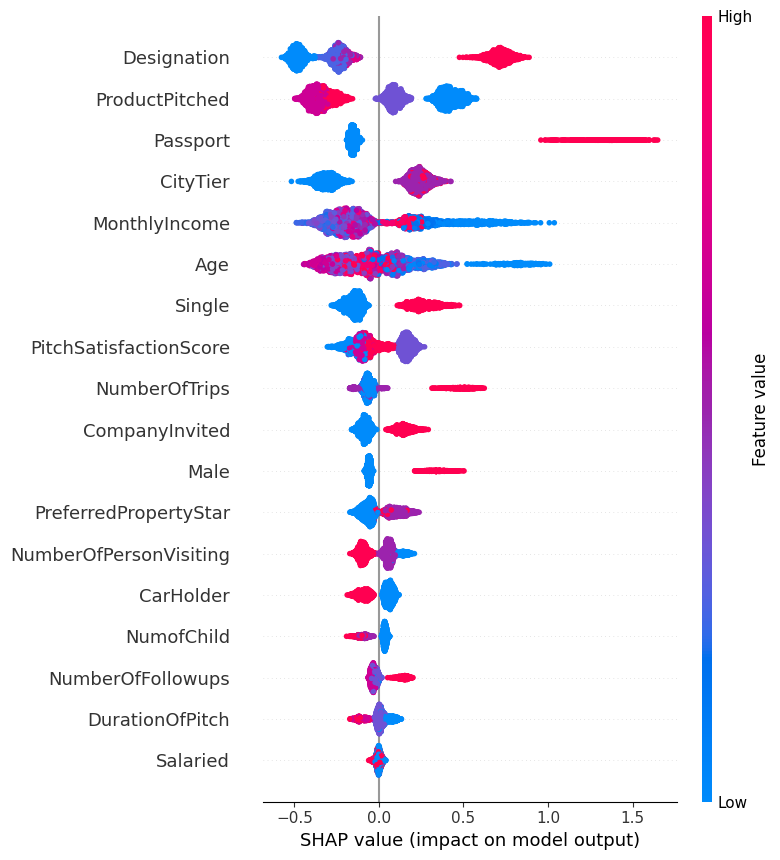

In [ ]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()
explainer = shap.TreeExplainer(model=models[0])
# 横軸：SHAP値 (0からの貢献度、右=プラスの影響)
# 縦軸：特徴量 (上にあるほど重要)
# 色：その特徴の値 (赤=大きい値、青=小さい値)
# ① SHAPのexplainerを作成
explainer = shap.TreeExplainer(models[0])
# ② SHAP値を計算（X_trainは学習に使った特徴量データ）
shap_values = explainer.shap_values(train.drop("ProdTaken",axis=1))
# ③ summary plotで全体の重要度と分布を見る
shap.summary_plot(shap_values, train.drop("ProdTaken",axis=1))

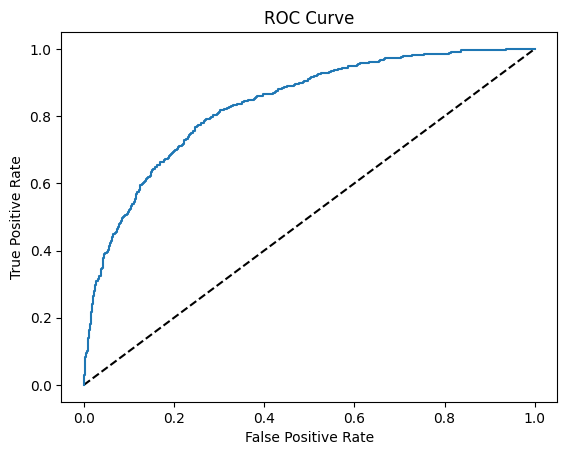

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(train[TARGET],oof_lgb)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

7. 提出

In [156]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [157]:
# テストデータを用いて予測します。
predict0 = models[0].predict(test)
predict1 = models[1].predict(test)
predict2 = models[2].predict(test)
predict = (predict0 + predict1 + predict2) / 3
submit[1] = predict

In [158]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)